# Эксперименты по восстановлению профилей дисперсий для NGC338 (UGC624) - по обрезанному профилю

Сначала всякие настройки и импорты

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import poly1d, polyfit, power
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import PIL as pil
import heapq
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.cm as cm
%matplotlib inline

# %install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.1
OS Windows 7 6.1.7601 SP1
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
Fri Apr 15 01:40:53 2016 RTZ 2 (зима)

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

скрипт для построения Table of Contents

In [2]:
%%javascript 
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
#Размер изображений
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 12

#Наклон галактики по данным Засова 2012
incl=64.0

#Масштаб пк/секунда из NED
scale=311.0

cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)

#Эффективный радиус балджа
r_eb = 15.

## 1. Наблюдательные данные

Всякие картинки и БД для большего удобства:

In [4]:
os.chdir("C:\\science\\2FInstability\\data\\ngc338")
try:
    from PIL import Image
except:
    import Image

Посмотрим теперь на все доступные даные по кривым вращения. Т.к. некоторые из них скорректированы, а некоторые нет, разобьем этот этап на несколько шагов.

[]

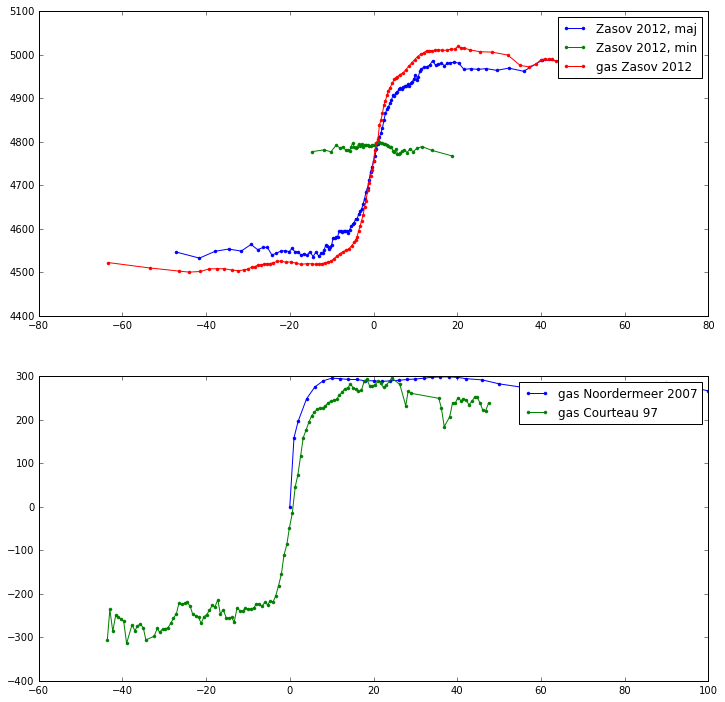

In [5]:
# Данные по звездной кинематике Засова 2012 вдоль большей полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_ma.dat", float)
r_ma, vel_ma, e_vel_ma, sig_ma, e_sig_ma = zip(*zasov_raw_data)

# Данные по звездной кинематике Засова 2012 вдоль малой полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_mi.dat", float)
r_mi, vel_mi, e_vel_mi, sig_mi, e_sig_mi = zip(*zasov_raw_data)

# Данные по кинематике газа Засова 2012 вдоль большой полуоси, не исправленные за наклон (они же Катков)
zasov_raw_data = np.loadtxt("v_gas_ma.dat", float)
r_g, vel_g, e_vel_g = zip(*zasov_raw_data)

# Данные по кинематике газа Noordermeer 2007 (исправлено за наклон)
wsrt_raw_data = np.loadtxt("v_gas_WSRT.dat", float)
r_wsrt, vel_wsrt, e_vel_wsrt = zip(*wsrt_raw_data)

# Данные по кинематике газа Courteau 97 (не исправлено за наклон)
court_raw_data = np.loadtxt("v_gas_Court.dat", float)
r_court, vel_court, e_vel_court = zip(*court_raw_data)


fig, subplot = plt.subplots(2, 1)
subplot[0].plot(r_ma, vel_ma, '.-', label="Zasov 2012, maj")
subplot[0].plot(r_mi, vel_mi, '.-', label="Zasov 2012, min")
subplot[0].plot(r_g, vel_g, '.-', label="gas Zasov 2012")
subplot[0].legend()
subplot[1].plot(r_wsrt, vel_wsrt, '.-', label="gas Noordermeer 2007")
subplot[1].plot(r_court, vel_court, '.-', label="gas Courteau 97")
subplot[1].legend()
plt.plot()

[]

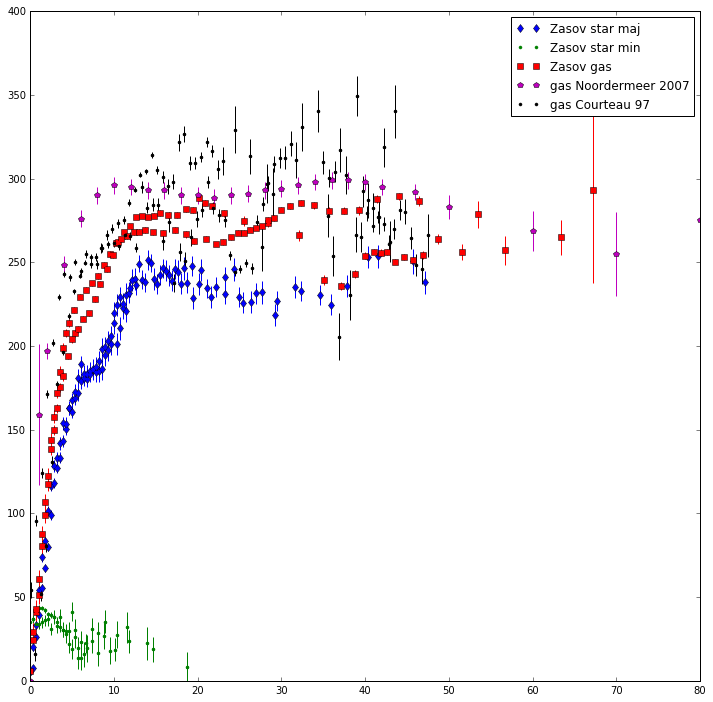

In [6]:
def incline_velocity(v, angle):
    return v / sin(angle * pi / 180)

# Переносит центр в (r0,v0) и перегибает кривую вращения, 
# а также исправляет за наклон если необходимо
def correct_rotation_curve(rdata, vdata, dvdata, r0, v0, incl):
    rdata_tmp = [abs(r-r0) for r in rdata]
    vdata_tmp = [incline_velocity(abs(v-v0), incl) for v in vdata]
    data = zip(rdata_tmp, vdata_tmp, dvdata)
    data.sort()
    return zip(*data)

b_vel = 4760

r_ma_b, vel_ma_b, e_vel_b = correct_rotation_curve(r_ma, vel_ma, e_vel_ma,  0.0, b_vel, incl)

r_mi_b, vel_mi_b, e_vel_mi_b = correct_rotation_curve(r_mi, vel_mi, e_vel_mi,  0.0, b_vel, incl)

r_g_b, vel_g_b, e_vel_g_b = correct_rotation_curve(r_g, vel_g, e_vel_g,  0.0, b_vel, incl)

r_c_b, vel_c_b, e_vel_c_b = correct_rotation_curve(r_court, vel_court, e_vel_court,  0.0, 0.0, incl)


plt.plot(r_ma_b, vel_ma_b, 'd', label = 'Zasov star maj')
plt.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_b, vel_mi_b, '.', label = 'Zasov star min', color='green')
plt.errorbar(r_mi_b, vel_mi_b, yerr=e_vel_mi_b, fmt='.', marker='.', mew=0, color='green')
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='red')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
plt.plot(r_wsrt, vel_wsrt, 'p', label="gas Noordermeer 2007", color='m')
plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')
plt.plot(r_c_b, vel_c_b, '.', label = 'gas Courteau 97', color='black')
plt.errorbar(r_c_b, vel_c_b, yerr=e_vel_c_b, fmt='.', marker='.', mew=0, color='black')
plt.xlim(0, 80.0)
plt.ylim(0)
plt.legend()
plt.plot()

В дальнейшем используем только засовские данные по звездам по большой полуоси и газу. Приблизим первую из них полиномом. 

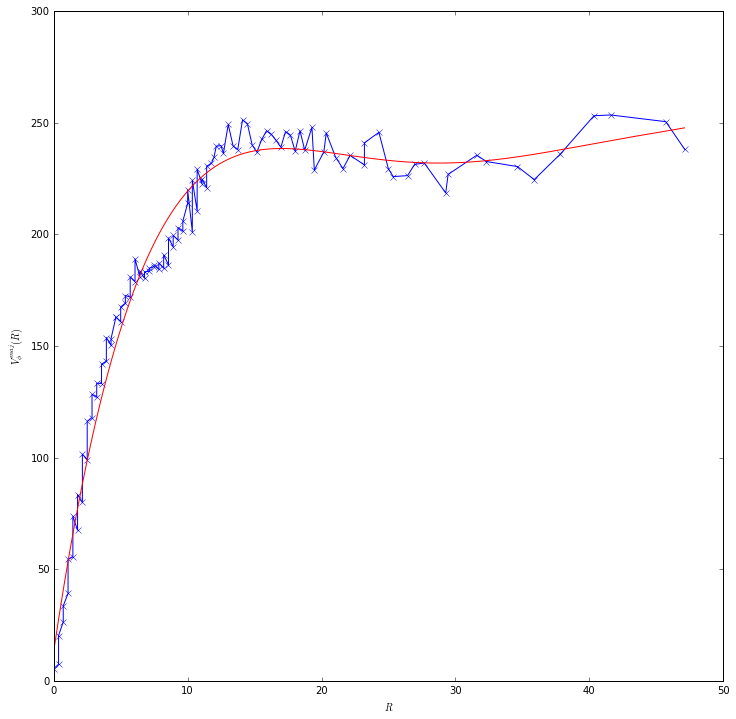

In [7]:
# poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=7))
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=5))


plt.plot(r_ma_b, vel_ma_b, 'x-', color='blue', markersize=6)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

Кривая вращения нам нужна для нахождения соотношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, которое описывается уравнением ${\displaystyle \sigma_{\varphi}^{2}/\sigma_{R}^{2}=0.5\left(1+\frac{R}{\bar{v}_{\varphi}}\frac{d\bar{v}_{\varphi}}{dR}\right)}$ (Binney & Tremaine, 1987) и приближается гладко функцией $f=0.5(1+e^{-R/R_{0}}),$ где $R_{0}$ --- характерный масштаб. 

${\bf Примечание:}$ Такое приближение оправдано следующими соображениями. Для равновесного диска верно уравнение, описанное выше. Для твердотельного участка вращения в центральных областях выражение в скобках равно 2, а $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=1$. На плоском участке кривой вращения на периферии диска $\sigma_{\varphi}^{2}/\sigma_{R}^{2}\thickapprox0.5$. Функция $f$ как раз аппроксимирует такое поведение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$.

Изобразим получившийся профиль $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, вычисляемый через производную полинома:

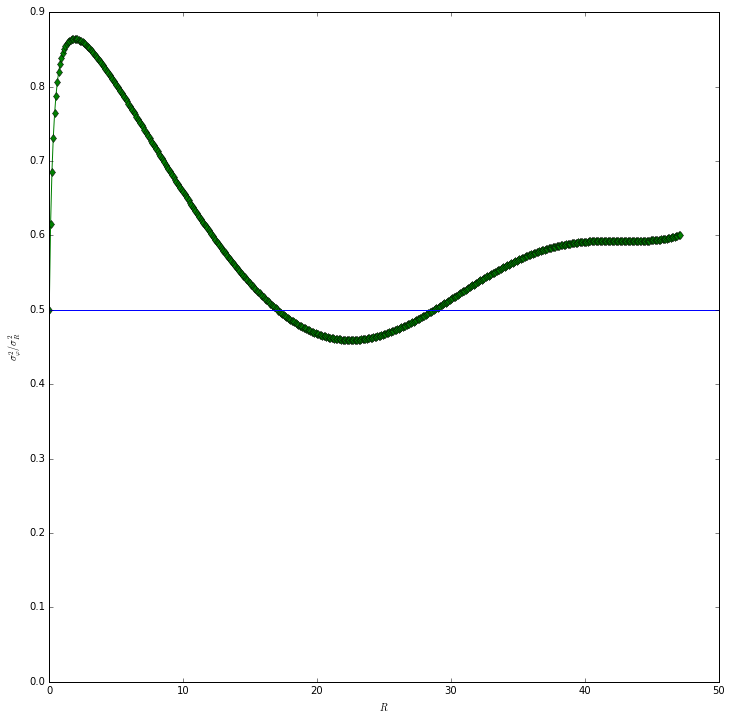

In [8]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

plt.plot(test_points, [sigPhi_to_sigR_real(R) for R in test_points], 'd-', color='green')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.xlabel('$R$')
plt.ylabel(r"$\sigma_{\varphi}^2/\sigma_{R}^2$")
plt.ylim(0)
plt.show()

Найдем теперь характерный масштаб $f=0.5(1+e^{-R/R_{0}})$:

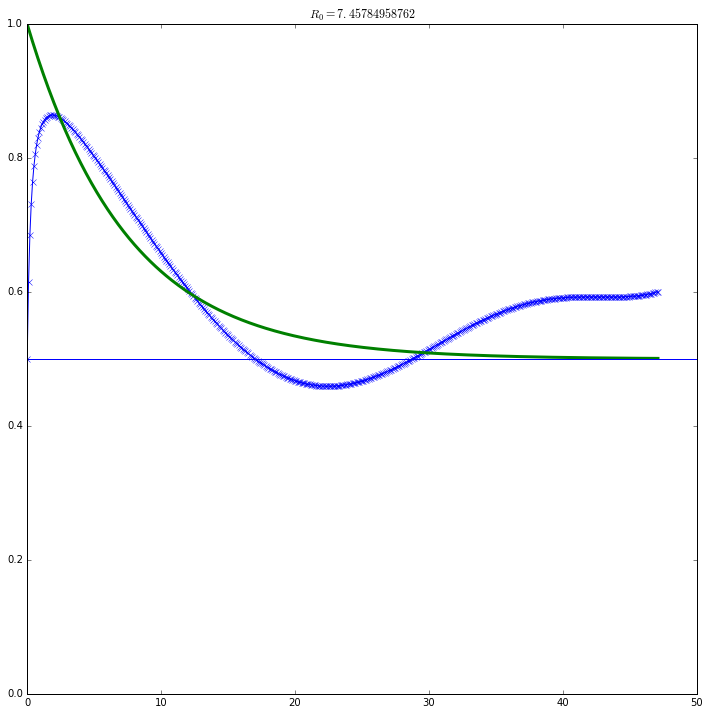

In [9]:
def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 'x-')
plt.plot(xdata, [f(p, Ro) for p in xdata], '-', linewidth=3.0)
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0)
plt.show()

Теперь знаем значение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$ в любой точке, заведем соответствующую функцию:

In [10]:
def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

Построим графики дисперсий скоростей на луче зрения вдоль большой и малой оси ($\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$):

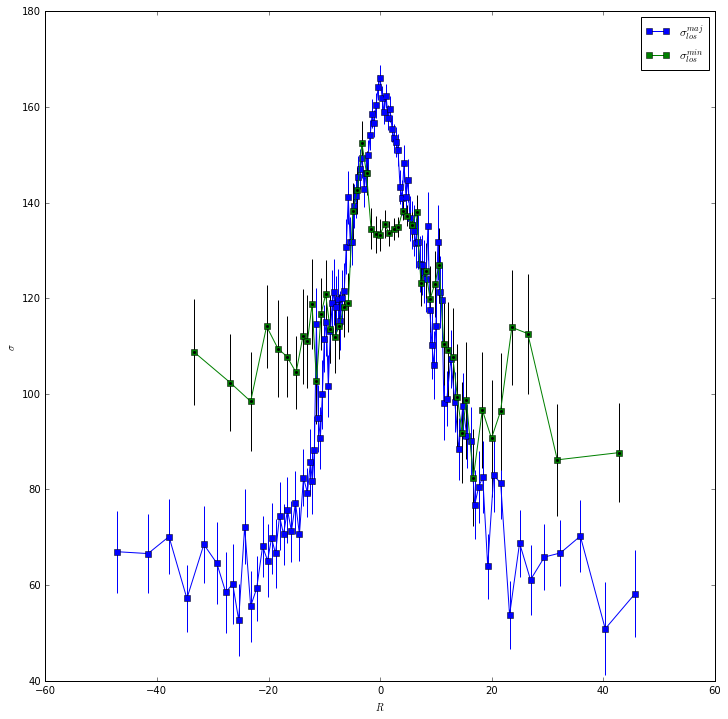

In [11]:
# Исправляем значения вдоль малой оси на синус угла:    
def correct_min(R):    
    return R / cos(incl * pi / 180) 

r_mi_extend = map(correct_min, r_mi)
    
plt.plot(r_ma, sig_ma, 's-', label='$\sigma_{los}^{maj}$')
plt.errorbar(r_ma, sig_ma, yerr=e_sig_ma, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_extend, sig_mi, 's-', label='$\sigma_{los}^{min}$')
plt.errorbar(r_mi_extend, sig_mi, yerr=e_sig_mi, fmt='.', marker='.', mew=0, color='black')
plt.xlabel('$R$')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

Перегнем и приблизим полиномами:

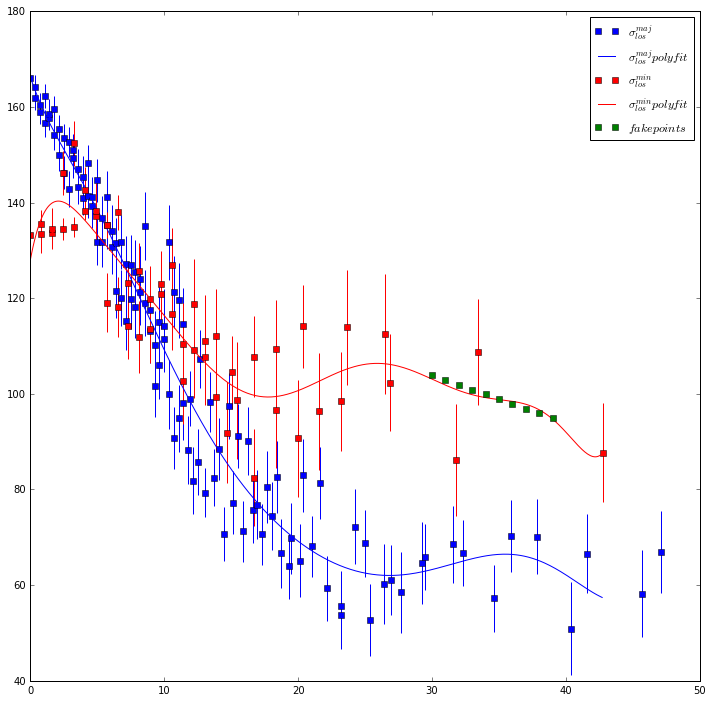

In [12]:
bind_curve = lambda p: (abs(p[0]), abs(p[1]), p[2])
sig_maj_data = zip(r_ma, sig_ma, e_sig_ma)
sig_maj_data = map(bind_curve, sig_maj_data)
sig_maj_data.sort()
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

poly_sig_maj = poly1d(polyfit(radii_maj, sig_maj_p, deg=9))

sig_min_data = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data = map(bind_curve, sig_min_data)
sig_min_data.sort()
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

# Добавляем лишние точки чтобы протянуть дальше
num_fake_points = 10; expscale = 100.0
fake_radii, fake_sig = zip(*[(29.0 + i, 105*exp(- i / expscale )) for i in range(1, num_fake_points+1)])

poly_sig_min = poly1d(polyfit(radii_min + fake_radii, sig_min_p + fake_sig, deg=9))

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
# plt.ylim(40, 200)
plt.show()

Посчитаем величину невязок для полученного приближения:

In [13]:
sqerr_maj = sum(power([poly_sig_maj(p[0]) - p[1] for p in sig_maj_data], 2))
sqerr_min = sum(power([poly_sig_min(p[0]) - p[1] for p in sig_min_data], 2))

chi2_maj = sqerr_maj / len(sig_maj_p)
chi2_min = sqerr_min / len(sig_min_p)

print "Poly chi^2 for maj full = %s, mean = %s" % (sqerr_maj, chi2_maj)
print "Poly chi^2 for min full = %s, mean = %s" % (sqerr_min, chi2_min)

Poly chi^2 for maj full = 6018.46868188, mean = 53.2607847954
Poly chi^2 for min full = 2975.50305433, mean = 57.2212125832


Теперь обрежем центральную часть и в дальнейшем будем работать с обрезанными данными:

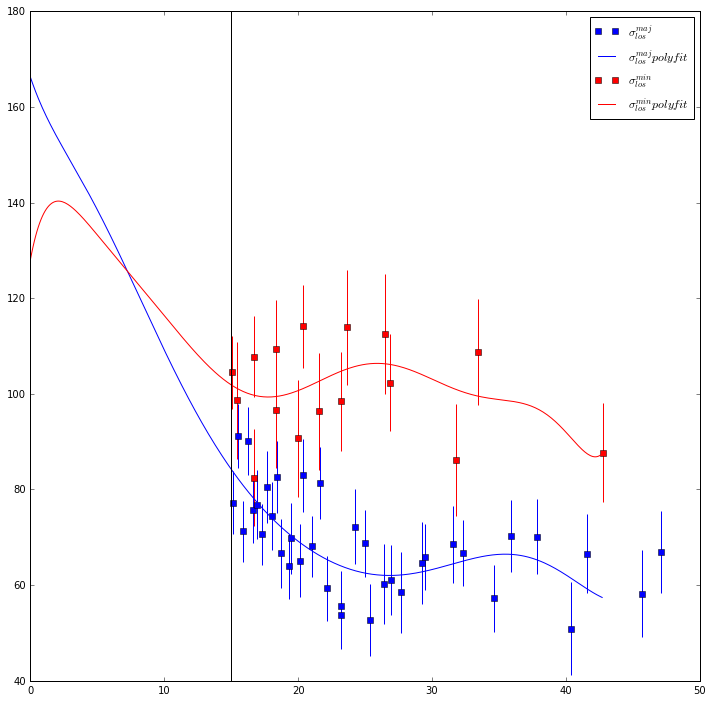

In [14]:
# Граница. по которой обрезаем
# cutted = 9.
cutted = r_eb

sig_maj_data = zip(radii_maj, sig_maj_p, e_sig_maj_p)
sig_maj_data = filter(lambda l: l[0] > cutted, sig_maj_data)
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

sig_min_data = zip(radii_min, sig_min_p, e_sig_min_p)
sig_min_data = filter(lambda l: l[0] > cutted, sig_min_data)
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.axvline(x=cutted, color='black')
plt.legend()
plt.show()

Приблизим сплайнами ($k=3$), а весовую функцию возьмем $w(err)=\frac{1}{1+{err}^2}$:  

[]

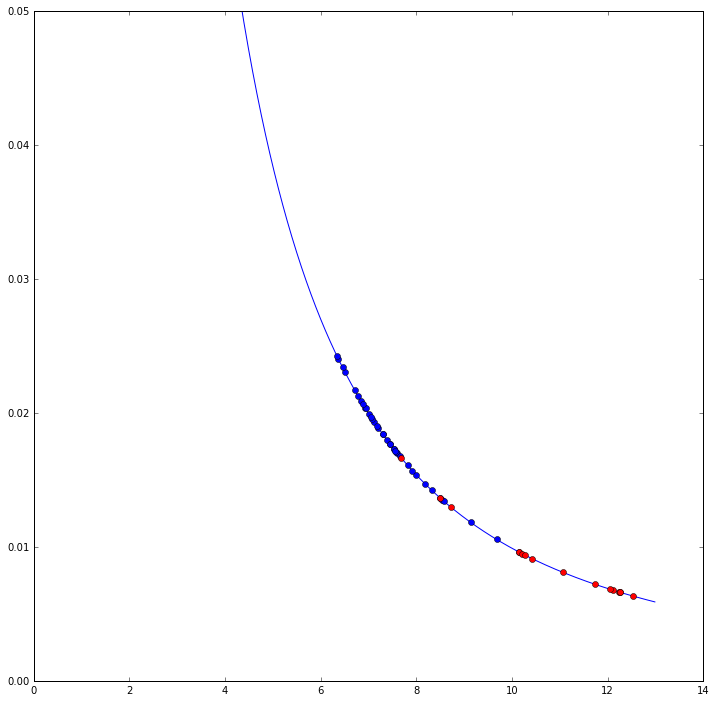

In [15]:
def w(arr):
    return map(lambda l: 1/(1. + l**2), arr)

xx = np.arange(0., 13., 0.01)
plt.plot(xx, w(xx), '-')
plt.plot(e_sig_maj_p, w(e_sig_maj_p), 'bo')
plt.plot(e_sig_min_p, w(e_sig_min_p), 'ro')
plt.ylim(0., 0.05)
plt.plot()

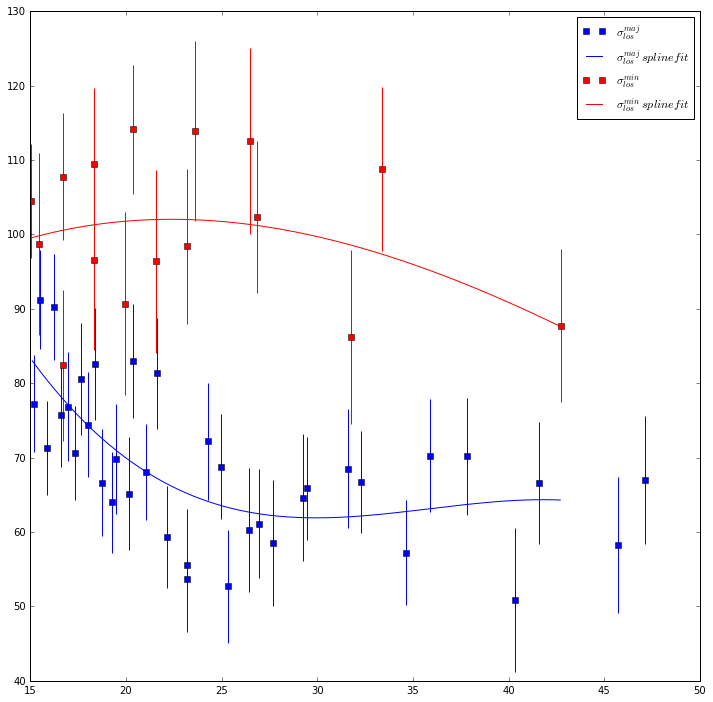

In [16]:
import scipy.interpolate as inter
points = filter(lambda l: l > cutted, points)

spl_maj = inter.UnivariateSpline (radii_maj[::-1], sig_maj_p[::-1], k=3, s=10000., w=w(e_sig_maj_p))
spl_min = inter.UnivariateSpline (radii_min[::-1], sig_min_p[::-1], k=3, s=10000., w=w(e_sig_min_p))

spl_min1 = spl_min

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min}\, splinefit$', color='red')
plt.axvline(x=cutted, color='black')
plt.legend()
plt.show()

## 2. Аналитическое восстановление профиля 

### 2.1 Из МНК

Методика восстановления профилей $\sigma_{R}(R)$, $\sigma_{\varphi}(R)$ и $\sigma_{z}(R)$ следующая. Представим, что $\sigma_{Z}/\sigma_{R} \equiv \alpha \equiv const$. Тогда, зная значения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=f(R)$ в каждой точке, получаем из уравнений, описанных выше: $$\sigma_{los,maj}^2=\sigma_R^2[f\sin^2i+\alpha^2\cos^2i]$$ $$\sigma_{los,min}^2=\sigma_R^2[\sin^2i+\alpha^2\cos^2i]$$
Представим теперь $\sigma_R(R)=\sigma_{R,0}\times F(R)$, где $F(0)=1$. Значение в квадратных скобках для $\sigma_{los,min}$ равно константе и, следуя предположению, получаем представление для дисперсии вдоль луча зрения для малой оси как $\sigma_{los,min}(R)=\sigma_{min,0}\times F(R)$. Очевидно $\sigma_{min,0} = \sigma_{los,min}(0)$, а значит мы знаем в каждой точке значение $F(R)=\sigma_{los,min(R)}/\sigma_{min,0}$. Описанная выше система уравнений вырождается в следующую:
$$\sigma_{los,maj}^2(R)=\frac{\sigma_{R,0}^2\sigma_{los,min}^2(R)[f\sin^2i+\alpha^2\cos^2i]}{\sigma_{min,0}^2}$$ $$\sigma_{min,0}^2=\sigma_{R,0}^2\sin^2i+\sigma_{R,0}^2\alpha^2\cos^2i$$
Сделаем замену: $\sigma_{R,0}^2\sin^2 i \equiv A,\ \sigma_{R,0}^2\cos^2 i\times \alpha^2 \equiv B$. Окончательно, имеем $N+1$ линейное уравнение для $N$ точек, которые можем решить МНК: 
$$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)\times \sigma_{min,0}^2 =\sigma_{los,min}^2(R_j)[Af(R_j)+B]\\
    \sigma_{min,0}^2=A+B
  \end{array}
\right.
$$

In [17]:
#Значение sig_los_min в cutted
# sig_min_0 = spl_min(cutted)
sig_min_0 = spl_min(0)

#Значение sig_R в cutted
sig_R_0 = 80.
# sig_R_0 = sig_min_0

alpha = 0.5

def sigR_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0

def sigZ_exp(R):
    return alpha * sigR_exp(R)

def sigPhi_exp(R):
    return sigPhi_to_sigR(R) * sigR_exp(R)

И восстановим профили $\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$. Связь профилей описывается следующими уравнениями: $$\sigma_{los,maj}^2=\sigma_{\varphi}^2\sin^2i+\sigma_Z^2\cos^2i$$ $$\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$$

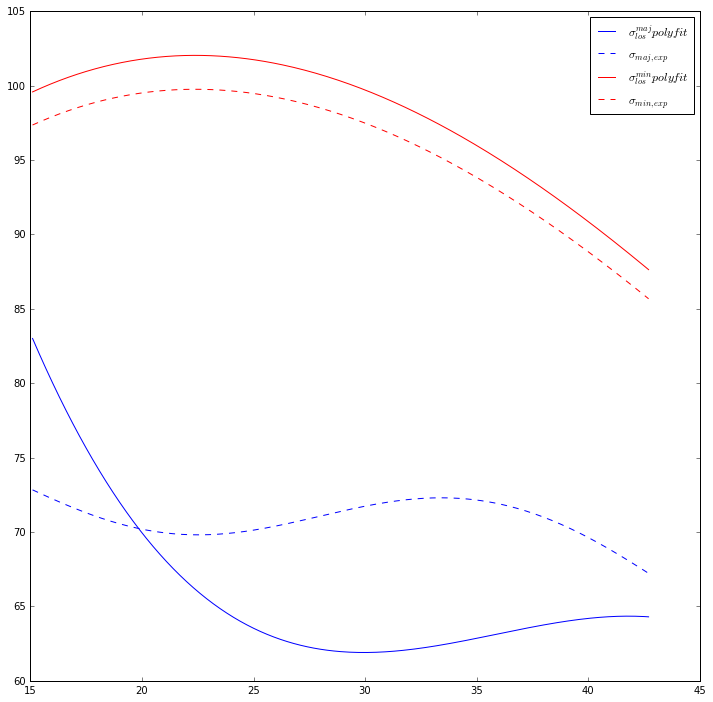

In [18]:
def sig_maj_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR_real(R) * sin_i**2 + alpha**2 * cos_i**2)
#     return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR(R)**2 * sin_i**2 + alpha**2 * cos_i**2)
#     return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sin_i**2 + alpha**2 * cos_i**2)
#     return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

plt.plot(points, spl_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue', label='$\sigma_{maj, exp}$')
plt.plot(points, spl_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red', label='$\sigma_{min, exp}$')
plt.legend()
plt.show()

### 2.2 Аналитически

Заметим, что можно было не решать систему МНК, а честно разрешить систему из двух уравнений $$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)\times \sigma_{min,0}^2 =\sigma_{los,min}^2(R_j)[Af(R_j)+B]\\
    \sigma_{min,0}^2=A+B
  \end{array}
\right.
$$ относительно $A$ и $B$ для почти любого $R_j$ (а лучше даже относительно начальных неизвестных - $\sigma_{R,0}$ и $\alpha$).
Решение: $$\sigma_{R,0}^2 = \frac{\sigma_{min,0}^2}{\sin^2 i}\times\frac{1}{f(R)-1}\times(P(R)-1)$$ $$\alpha^2 = \tan^2 i\frac{f(R) - P(R)}{P(R)-1},$$ $$P(R)=\frac{\sigma_{los,maj}^2(R)}{\sigma_{los, min}^2(R)}$$ Имеет смысл также искать не $\alpha$, а $\alpha\cdot\sigma_{R,0}=\sigma_{Z,0}$.

In [19]:
def P(R):
    """Отношение maj к min, как описано выше"""
    return (spl_maj(R)/spl_min(R))**2

def direct_solve_A(R):
    """Аналитически находим значение sig_R_0 для уравнения в точке R"""
    res = sig_min_0**2 * (P(R) - 1) / (sin_i**2 * (sigPhi_to_sigR(R)**2 - 1))
    return sqrt(res) if res > 0 else 0

def direct_solve_B(R):
    """Аналитически находим значение alpha для уравнения в точке R"""
    res = (sigPhi_to_sigR(R)**2 - P(R))/(P(R) - 1) * (sin_i/cos_i)**2
    return sqrt(res) if res > 0 else 0

def direct_find_sig_R_0(R):
    return direct_solve_A(R)

def direct_find_sig_Z_0(R):
    return direct_solve_A(R) * direct_solve_B(R)

Найдем значения $\sigma_{R,0}$ и $\sigma_{Z,0}$ для всех точек на большой оси:

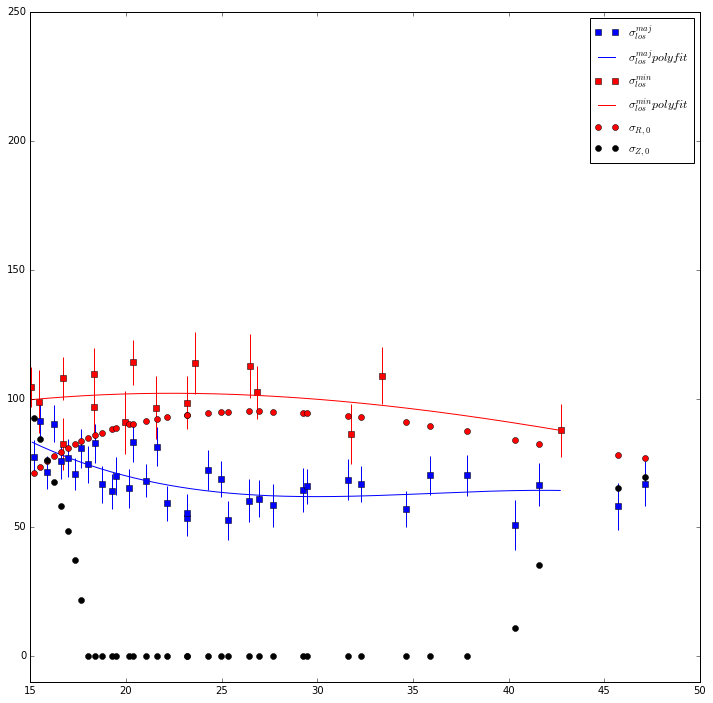

In [20]:
p_r = radii_maj

direct_sigR0 = map(direct_find_sig_R_0, p_r)
direct_sigZ0 = map(direct_find_sig_Z_0, p_r)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.plot(p_r, direct_sigZ0, 'o', color='k', label='$\sigma_{Z,0}$')

plt.legend()
plt.ylim(-10, 250)
plt.show()

**Неправильная картинка! Тут $\sigma_{R,0}$ - не одно и то же значение, а зависит от точки. Поэтому это неверные выводы. То же и для картинки в следующем методе (ниже), по всей видимости}**

Как видно - хорошо восстанавливаются значения $\sigma_{R,0}$ - лежат относительно одной прямой, найдем их среднее:

In [21]:
#Обрежем по 13
q=13.
ind_q = p_r.index(filter(lambda l: l > q, p_r)[0])

poly_q = poly1d(polyfit(p_r[ind_q:], direct_sigR0[ind_q:], deg=0))
print "sig_R poly mean = %s" % poly_q[0]

sig_R poly mean = 87.4265961525


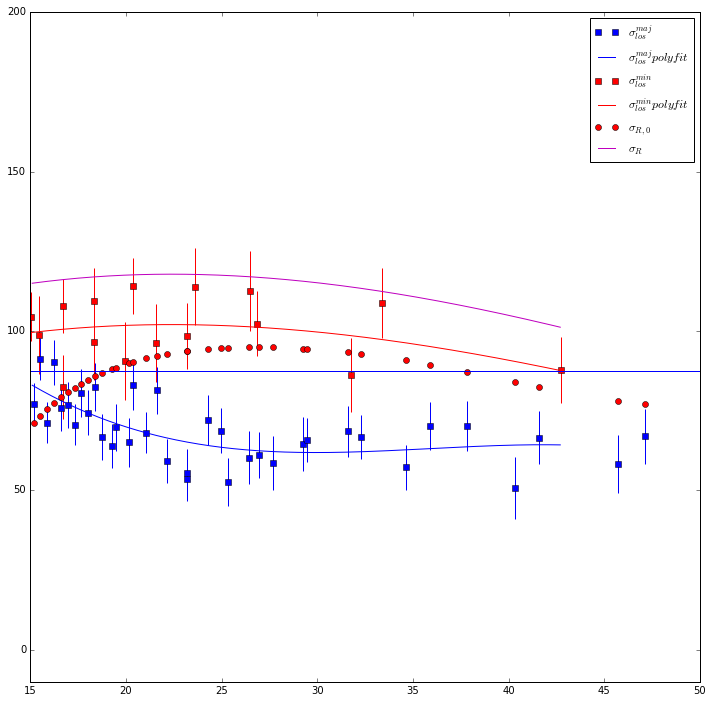

In [22]:
sig_R_0 = poly_q[0]

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.axhline(y=sig_R_0)

#Строим полученный на основе среднего профиль sig_R
plt.plot(points, spl_min(points)*sig_R_0/sig_min_0, label = '$\sigma_R$', color='m')

plt.legend()
plt.ylim(-10, 200)
plt.show()

### 2.3 Из верхней оценки

Как мы видим, значения профиля дисперсии $\sigma_R(R)$ восстанавливаются довольно надежно, однако оказываются по-видимому больше реальных и поэтому не получается восстановить профиль в вертикальном направлении. Попробуем оценить, насколько этот вклад оказывается переоценен в данном случае. Известно, что отношение $\sigma_Z/\sigma_R$ не может быть меньше некоего порогового значения, в противном случае галактика будет неустойчива к осесимметричным изгибным возмущениям плотности. Многие авторы оценивали эту величину, в том числе Засов, однако последния статья Сотниковой и Радионова "Bending instability in galactic discs. Advocacy of the linear theory" (2013, http://arxiv.org/abs/1306.5975) продемонстрировала, что искомое попроговое значение близко к таковому, полученному из линейной теории Тумре в 1966 год и равно примерно 0.3. Чем это ценно для нас? Если мы примем, что $\frac{\sigma_Z}{\sigma_R} \gtrsim 0.3,$ то, исходя из уравнения $\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$ можем получить оценку сверху на значения радиальной дисперсии: $$\frac{\sigma_{los,min}}{\sqrt{\sin^2i+0.09\cos^2i}} \gtrsim \sigma_R$$ Также аналогичную оценку, только чуть более сложную, можно сделать и для данных вдоль большой оси.

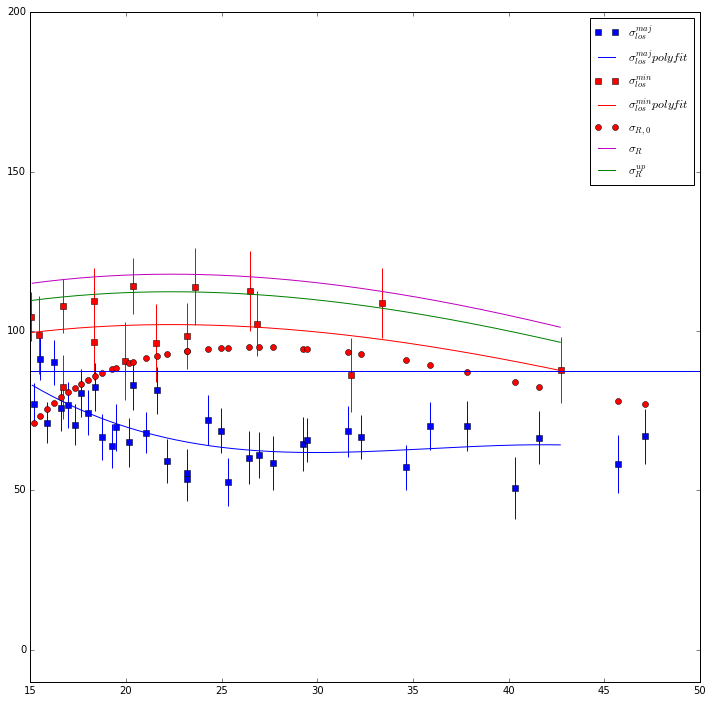

In [23]:
def sig_R_upper_lim(R, alpha):
    """Оценка сверху на sigR(R)"""
    return spl_min(R)/sqrt(sin_i**2 + alpha**2 * cos_i**2)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')

plt.plot(p_r, direct_sigR0, 'o', color='r', label='$\sigma_{R,0}$')
plt.axhline(y=sig_R_0)
plt.plot(points, spl_min(points)*sig_R_0/sig_min_0, label = '$\sigma_R$', color='m')
plt.plot(points, [sig_R_upper_lim(R, 0.3) for R in points], label = '$\sigma_R^{up}$', color='g')

plt.legend()
plt.ylim(-10, 200)
plt.show()

Как видим, значения действительно оказались нормальными вполне.

### 2.4 Перебор значений

Теперь то, с чего надо было начинать - построим картинки для разных значений $\alpha$ и $\sigma_{R,0}$. Для того, чтобы найти где минимум, попробуем построить просто двумерные карты $\chi^2$ для разных $\sigma_{R,0}$  $\alpha$: (это очень долго, так что пересчитывать в крайнем случае, а так - храним посчитанные данные в файлах) 

$$\chi^2 = \frac{1}{N-n}\Sigma\frac{(observed-expected)^2}{\sigma^2(observed)}$$ (http://en.wikipedia.org/wiki/Goodness_of_fit#Example)

In [24]:
alphas = np.arange(0.25, 1., 0.01)
# sigmas = np.arange(100.0, 200, 0.25)
sigmas = np.arange(40.0, 200, 0.25)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
#             sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
#             sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
#             sqerr_maj = sum([(sig_maj_exp(p[0]) - p[1])**2/p[2]**2 for p in sig_maj_data])
#             sqerr_min = sum([(sig_min_exp(p[0]) - p[1])**2/p[2]**2 for p in sig_min_data])
            sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
            sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min

pics_path = '.cutted\\pics\\'
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map.npy'):
    image = np.load(pics_path + "chi2_map.npy")
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)
    np.save(pics_path + 'chi2_map', image)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

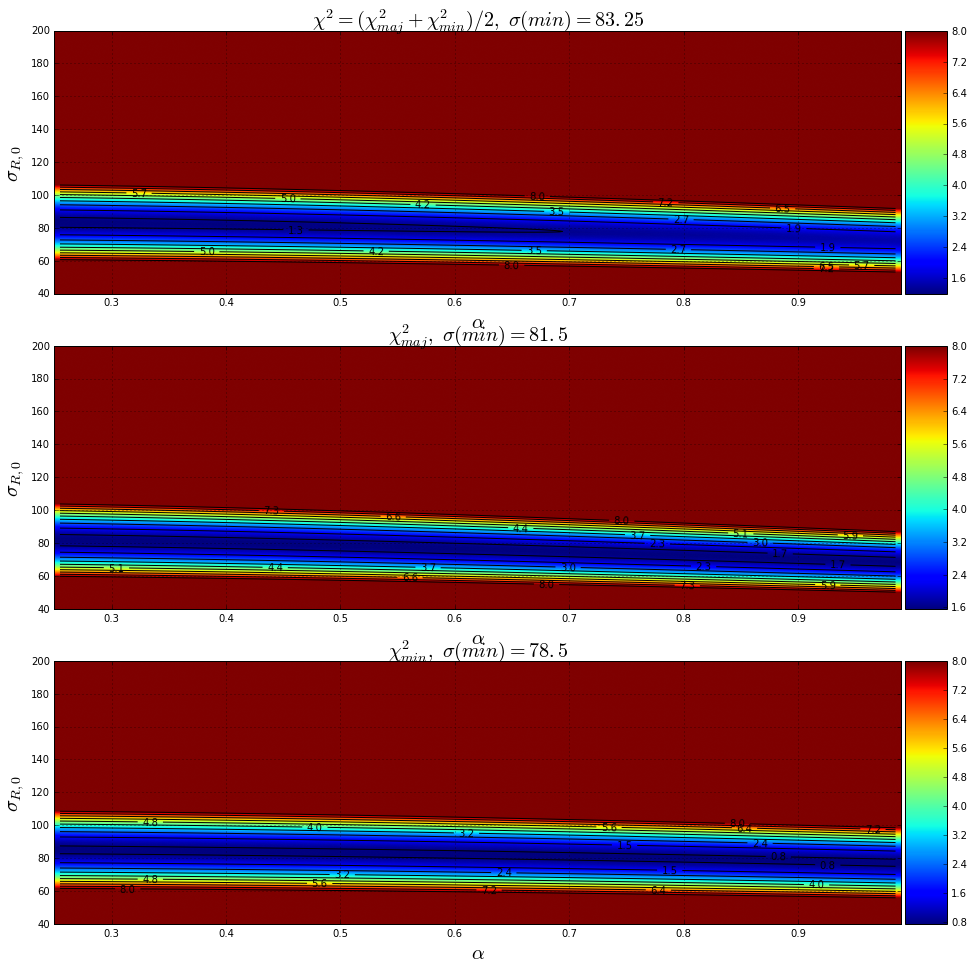

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    '''Рисуем получившиеся карты.
    Colormaps: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps'''
    if image is not None:
        if log_scale:
            image_log = np.apply_along_axis(np.log, 1, image)
            vmax = image_log.max()
        else:
            image_log = image
        if is_contour:
            norm = plt.cm.colors.Normalize(vmax=image.max(), vmin=-image.max())
            cmap = plt.cm.PRGn
            levels = np.concatenate([np.array([image_log.min()*1.1,]), np.linspace(start=image_log.min(), stop=vmax, num=10)])
            levels = sorted(levels)
            cset=ax.contour(image_log, levels, hold='on', colors = 'k', origin='lower', 
                            extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
            ax.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
        im = ax.imshow(image_log, cmap='jet', vmin=image_log.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(np.where(image == image.min())[0])]        
        ax.set_title(title + '$,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[16,16])
plot_chi2_map(image, axes[0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=True, vmax=8.)
plot_chi2_map(image_maj, axes[1], log_scale=False, title='$\chi^2_{maj}$', is_contour=True, vmax=8.)
plot_chi2_map(image_min, axes[2], log_scale=False, title='$\chi^2_{min}$', is_contour=True, vmax=8.)
plt.show()

Видно для малой оси неплохое такое вырождение. Попробуем на этой карте взять два среза: 
- вдоль вырождения по малой оси
- вдоль профиля $\sigma_R = \frac{\sigma_{los, min}}{\sqrt{\sin^2i+\alpha^2\cos^2i}}$, т.к. именно так зависят наши параметры друг от друга (т.е. параметризация по сути однопараметрическая)
Определим для этого срез по малой оси: 

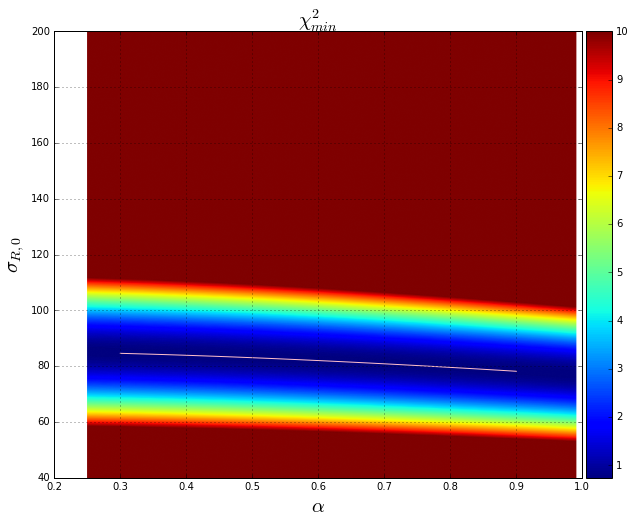

In [26]:
plt.figure(figsize=(10,8))
ax = plt.gca()
min_sigmas = np.where(image_min < image_min.min() + 0.5)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
im = ax.imshow(image_min, cmap='jet', vmin=image_min.min(), vmax=10., interpolation='spline16', 
           origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
ax.set_title('$\chi^2_{min}$', size=20.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)
ax.grid()
xx = np.arange(0.3, 0.9, 0.01)
ax.plot(xx, poly_slice(xx), color='pink')
plt.show()

In [27]:
alphas = np.arange(0.2, 0.9, 0.01)
err_maj, err_maj_p = [], []
err_min, err_min_p = [], []
err_mean, err_mean_p = [], []
main_slice = lambda l: sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)

for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
#     err_maj.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
#     err_min.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    err_maj.append(sqerr_maj)
    err_min.append(sqerr_min)
    err_mean.append(0.5*(err_maj[-1] + err_min[-1]))
    sig_R_0 = poly_slice(alpha)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
#     err_maj.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
#     err_min.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    err_maj_p.append(sqerr_maj)
    err_min_p.append(sqerr_min)
    err_mean_p.append(0.5*(err_maj_p[-1] + err_min_p[-1]))

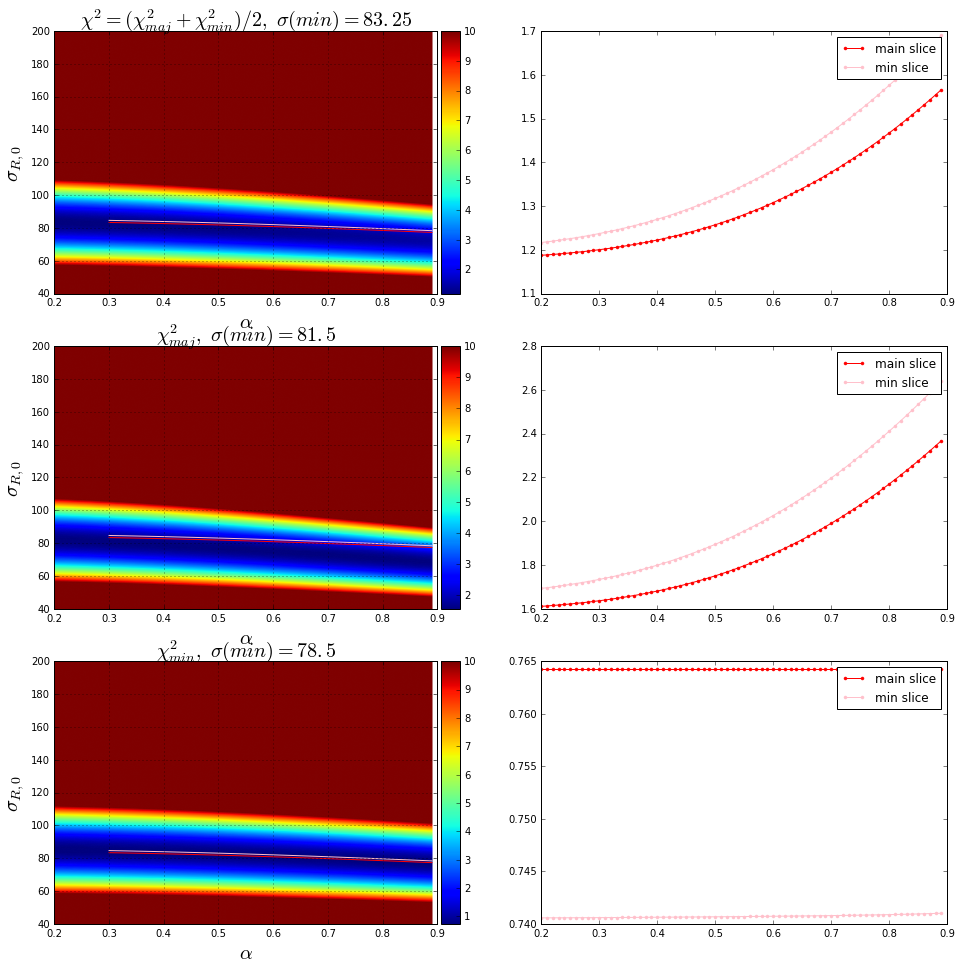

In [28]:
xx = np.arange(0.3, 0.89, 0.01)
    
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=False, sharey=False, figsize=[16,16])

plot_chi2_map(image, axes[0, 0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=False, vmax=10.)
axes[0,0].plot(xx, map(main_slice, xx), color='red')
axes[0,0].plot(xx, poly_slice(xx), color='pink')

axes[0, 1].plot(alphas, err_mean, '.-', label = 'main slice', color='red')
axes[0, 1].plot(alphas, err_mean_p, '.-', label = 'min slice', color='pink'); axes[0, 1].legend()

plot_chi2_map(image_maj, axes[1, 0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=10.)
axes[1,0].plot(xx, map(main_slice, xx), color='red')
axes[1,0].plot(xx, poly_slice(xx), color='pink')

axes[1, 1].plot(alphas, err_maj, '.-', label = 'main slice', color= 'red')
axes[1, 1].plot(alphas, err_maj_p, '.-', label = 'min slice', color= 'pink'); axes[1, 1].legend()

plot_chi2_map(image_min, axes[2, 0], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=10.)
axes[2,0].plot(xx, map(main_slice, xx), color='red')
axes[2,0].plot(xx, poly_slice(xx), color='pink')

axes[2, 1].plot(alphas, err_min, '.-', label = 'main slice', color= 'red')
axes[2, 1].plot(alphas, err_min_p, '.-', label = 'min slice', color='pink'); axes[2, 1].legend()

plt.show()

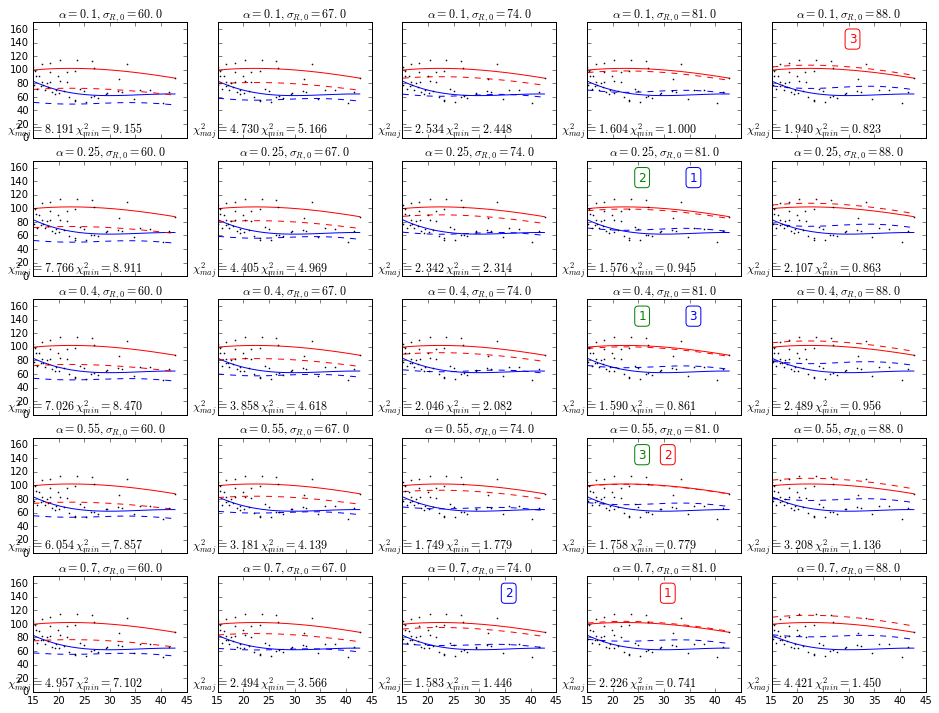

In [29]:
# Перебор alpha
alphas = np.arange(0.1, 0.85, 0.15)

# Перебор sig_R_0
# sigmas = np.arange(130., 165., 7.)
sigmas = np.arange(60., 95., 7.)

# Те картинки, на которые стоит обратить особое внимание
good_pics = []

def plot_ranges(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    '''
    Для всех предложенных вариантов sigR и alpha
    рисует графики исходных и восстановленных дисперсий скоростей los.
    Если calc_chi = True, то также считает ошибку по наблюдаемым точкам.
    Если ошибка считается, то отмечаются best_err лучших (наименьших) результата.
    Синий - для большой оси, красный - малой, зеленый - полусумма.
    Изменяет глобальные значения sig_R_0 и alpha!'''
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,12])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            ax.plot(points, spl_maj(points), '-', color='blue')
            ax.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue')
            ax.plot(points, spl_min(points), '-', color='red')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            ax.plot(radii_min, sig_min_p, 's', color='red', ms=1)
            ax.plot(radii_maj, sig_maj_p, 's', color='blue', ms=1)
            if calc_chi:
                sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
                sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
#                 sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
#                 sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
                ax.text(10, 5, "$\chi^2_{maj}=%5.3f\, \chi^2_{min}=%5.3f$" % (sqerr_maj, sqerr_min), fontsize=12)
                sqerr_majs.append(sqerr_maj);sqerr_mins.append(sqerr_min)
                sqerr_mean.append(0.5*sqerr_maj+0.5*sqerr_min)
            ax.set_ylim(0, 170)
            ax.set_xlim(cutted, 45)
            if (plt_index/ncols, plt_index % ncols) in good_pics:
                ax.plot([40], [200], 'o', markersize=12., color=(0.2,1.0,0.))
            plt_index = plt_index + 1
    if calc_chi:
        best_maj_err = heapq.nsmallest(best_err, sqerr_majs)
        for b_maj in best_maj_err:
            b_maj_ind = sqerr_majs.index(b_maj)
            ax = axes[b_maj_ind/ncols, b_maj_ind % ncols]
            #ax.plot([35], [200], 'o', markersize=12., color='b')
            ax.text(35, 140, "%s" % (best_maj_err.index(b_maj)+1), fontsize=12, color='b', 
                    bbox=dict(facecolor='none', edgecolor='b', boxstyle='round'))
        best_min_err = heapq.nsmallest(best_err, sqerr_mins)
        for b_min in best_min_err:
            b_min_ind = sqerr_mins.index(b_min)
            ax = axes[b_min_ind/ncols, b_min_ind % ncols]
            #ax.plot([30], [200], 'o', markersize=12., color='r')
            ax.text(30, 140, "%s" % (best_min_err.index(b_min)+1), fontsize=12, color='r', 
                    bbox=dict(facecolor='none', edgecolor='r', boxstyle='round'))
        best_mean_err = heapq.nsmallest(best_err, sqerr_mean)
        for b_mean in best_mean_err:
            b_mean_ind = sqerr_mean.index(b_mean)
            ax = axes[b_mean_ind/ncols, b_mean_ind % ncols]
            #ax.plot([25], [200], 's', markersize=12., color='g')
            ax.text(25, 140, "%s" % (best_mean_err.index(b_mean)+1), fontsize=12, color='g', 
                    bbox=dict(facecolor='none', edgecolor='g', boxstyle='round'))

plot_ranges(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

### 2.5 Из ассимметричного дрифта

Интересный вариант для тех галактик, в которых есть данные по газу. Разница между скоростями вращения звезд и газа вокруг центра галактики называется ассиметричным сдвигом и описывается следующим уравнением (Binney & Tremaine 1987): $$v_{\mathrm{c}}^{2}-\bar{v}_{\varphi}^{2}=\sigma_{R}^{2}\left(\frac{\sigma_{\varphi}^{2}}{\sigma_{R}^{2}}-1-\frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}-\frac{\partial\ln\sigma_{R}^{2}}{\partial\ln R}\right)\,$$
Отношение ${\displaystyle \frac{\sigma_{\varphi}^{2}}{\sigma_{R}^{2}}}$ знаем из соответствующего уравнения. Поймем, как в этом выражении вычисляется логарифмическая производная ${\displaystyle \frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}}$. Если отношение массы к светимости принять постоянной вдоль радиуса величиной, то в производной ${\displaystyle \frac{\partial\ln\Sigma_{\mathrm{s}}}{\partial\ln R}}$ можно использовать поверхностную яркость звездного диска вместо поверхностной плотности $\Sigma_{\mathrm{s}}$ в тех полосах, которые трассируют старое звездное население. Это означает, что логарифмическая производная должна быть заменена отношением $-{\displaystyle \frac{R}{h_{\text{d}}}}\,,$ где $h_{\text{d}}$ --- экспоненциальный масштаб диска.

Таким образом, если мы восстановили профиль значений $\sigma_R$ и имеем представление о фотометрии диска галактики, то мы можем вычислить предполагаемый профиль газовой кривой вращения и сравнить его с истинным. В том случае, когда у нас нет данных по газу, мы можем их предсказать. Продемонстрируем это.

Фотометрию возьмем из диплома, тем более что там она была непротиворечивой, значение экспоненциального масштаба $h_r=12.9^{\prime\prime}$. Необходимую нам логарифмическую производную несложно посчитать, если приблизить профиль полиномом $\sigma_R(R) \equiv p(x)$: $$\frac{\partial\ln\sigma_{R}^{2}}{\partial\ln R} = \frac{2}{p(R)}\times\frac{\partial\ln p(e^{\ln R})}{\partial\ln R} = \frac{2Rp^{\prime}(R)}{p(R)}$$ Сделаем перебор по $\chi^2$:

Касательно производной - честнее считать так:  логарифмическая производная в AD не зависит от домножения на константу, а значит можно посчитать ее по профилю $\sigma_{los}^{min}$. Попробуем получить профиль радиальной дисперсии из этих данных:

C:\Anaconda\lib\site-packages\numpy\lib\polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


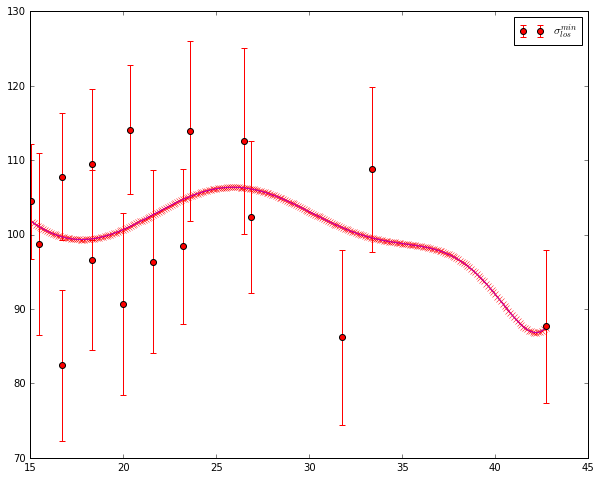

In [30]:
poly_min_R = poly1d(polyfit(points, [poly_sig_min(R) for R in points], deg=17))
fig = plt.figure(figsize=(10,8))
plt.plot(points, [poly_sig_min(R) for R in points], 'x-', color='red')
plt.plot(points, [poly_min_R(R) for R in points], '-', color='m')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, label='$\sigma_{los}^{min}$', fmt='.', marker='o', mew=1, color='red')
plt.legend()
plt.show()

def log_deriv(R):
    return 2*R * poly_min_R.deriv()(R) / poly_min_R(R)

Хвост кривой на рисунке выше начиная с 27 очень спекулятивен, а производную там вообще можно любую получить. Поэтому дрифт получим только до 27 секунд. 

In [31]:
# def log_deriv(R):
#     """Вычисление логарифмической производной sig_R,
#     для ассиметричного сдвига - как описано выше"""
#     return 2*R * poly_marj_R.deriv()(R) / poly_marj_R(R)


#Масштаб диска в секундах
h_d = 12.9
print "h_d = %s" % h_d

def asym_drift_value(R):
    """Вычисляем величину сдвига между квадратами скоростей газа и звезд"""
    return poly_marj_R(R)**2 * (sigPhi_to_sigR(R)**2 - 1 + R/h_d - log_deriv(R))

predict_drift = lambda l: asym_drift_value(l) + poly_star(l)**2 
predict_gas = lambda l: sqrt(predict_drift(l)) if predict_drift(l) > 0 else np.nan

h_d = 12.9


In [32]:
#От альфа не зависит
alpha = 0.5
sigmas = np.arange(60.0, 250, 2.5)

#Данные Засова по газу от 2'' до 26'', чтобы избегать nan и завалов на конце
gas_data_zasov = filter(lambda l: l[0] < 26. and l[0] > 2., zip(r_g_b, vel_g_b, e_vel_g_b))

gas_data_zasov = [l for l in gas_data_zasov if l[1] < 272]

def compute_chi2_drift(sigmas=()):
    result_err = []
    for i,si in enumerate(sigmas):
        global sig_R_0, poly_marj_R
        sig_R_0 = si
        #Приближаем полиномом для подсчета производной
        poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
        sqerr = calc_chi2_normal(zip(*gas_data_zasov)[1], zip(*gas_data_zasov)[2], 
                                 [predict_gas(r) for r in zip(*gas_data_zasov)[0]])
#         sqerr = sum(power([predict_gas(p[0]) - p[1] for p in gas_data_zasov], 2))/len(gas_data_zasov)
        result_err.append(sqerr)
    return result_err

# pics_path = '.cutted\\pics\\'
# if os.path.isfile(pics_path + 'drift_err.npy'):
#     drift_err = list(np.load(pics_path + "drift_err.npy"))
# else:
#     drift_err = compute_chi2_drift(sigmas=sigmas)
#     np.save(pics_path + 'drift_err', drift_err)
    
drift_err = compute_chi2_drift(sigmas=sigmas)
np.save(pics_path + 'drift_err', drift_err)
    
#Данные Засова по газу от 1'' до 40'', чтобы избегать nan
gas_data_zasov = filter(lambda l: l[0] < 40. and l[0] > 1., zip(r_g_b, vel_g_b, e_vel_g_b))

[]

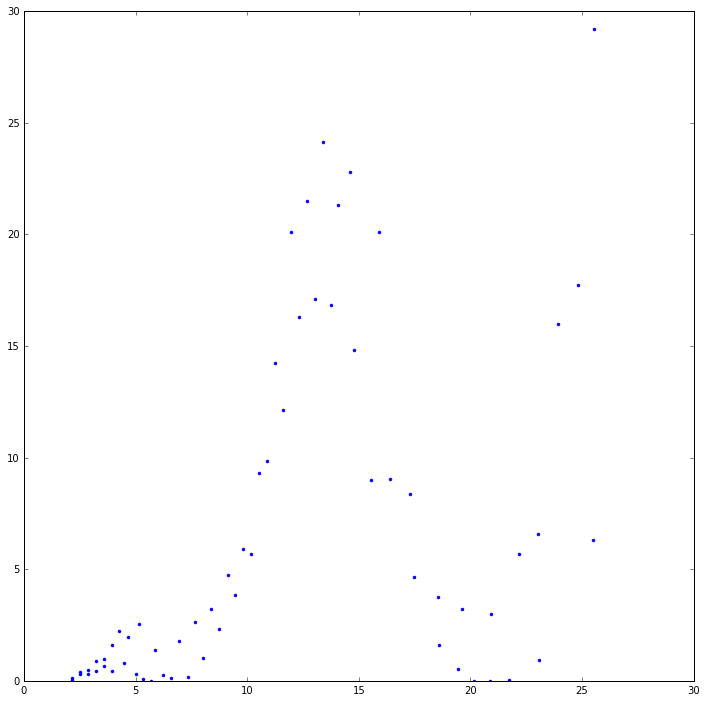

In [33]:
gas_data_zasov = filter(lambda l: l[0] < 26. and l[0] > 2., zip(r_g_b, vel_g_b, e_vel_g_b))

# gas_data_zasov = [l for l in gas_data_zasov if l[1] < 272]

sig_R_0 = 150

r, g, ge = zip(*gas_data_zasov)

poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
# dif2 = [abs(predict_gas(R) - g[np.where(r==R)[0][0]]) for R in filter(cut, r)]
N = len(gas_data_zasov)
dif2 = [abs(predict_gas(e[0]) - e[1])**2/(N * e[2]**2) for e in gas_data_zasov]

# plt.plot(r, g, '+', color='red')
# plt.plot(r, [predict_gas(l) for l in r], '+')
plt.plot(r, dif2, '.')
# plt.axhline(y=272)
plt.plot()

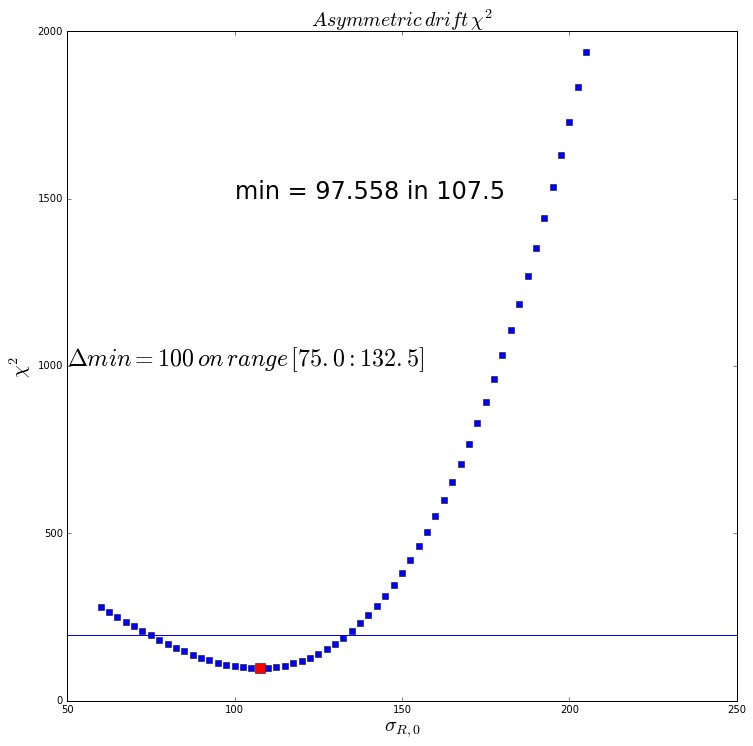

In [34]:
def plot_chi2_drift(sigmas, drifts):
    plt.plot(sigmas, drifts, 's')
    ind = drifts.index(min(drifts))
    value = drifts[ind]
    plt.plot(sigmas[ind], value, 's', color='red', ms=10.)
    plt.title('$Asymmetric\, drift\, \chi^2$', size=20.)
    plt.xlabel('$\sigma_{R,0}$', size=20.)
    plt.ylabel('$\chi^2$', size=20.)
    plt.ylim(0, 2000)
    plt.text(100, 1500, 'min = %.3f in %s' % (value, sigmas[ind]), size = 24.)
    plt.axhline(y=value+100)
    accep_val = filter(lambda l: l < value+100, drifts)
    ind_l = drifts.index(accep_val[0]); ind_r = drifts.index(accep_val[-1])
    plt.text(50, 1000, '$\Delta min=100\, on\, range\, [%s:%s]$' %(sigmas[ind_l], sigmas[ind_r]) , size = 24.)
    plt.show()
    
plot_chi2_drift(sigmas, drift_err)

In [35]:
# gas_data_zasov = filter(lambda l: l[0] < 26. and l[0] > 2., zip(r_g_b, vel_g_b, e_vel_g_b))
# sig_R_0 = 152
# poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
# # print [predict_gas(r) for r in zip(*gas_data_zasov)[0]]
# err = 0
# N = len(zip(*gas_data_zasov)[0])
# for p in zip(zip(*gas_data_zasov)[1], zip(*gas_data_zasov)[2], [predict_gas(r) for r in zip(*gas_data_zasov)[0]]):
#     err += ((p[0]-p[2])**2 / p[1]**2)/N
#     print '%.2f %.2f %.2f %.2f %.2f' %(err, p[0], p[1], p[2], ((abs(p[0]-p[2])/p[1])**2)/N)

Разрыв - из-за того, что NaN был. В целом картинка оочень хорошая - виден четкий минимум без широкого плато и все в том же примерно месте, что и раньше. Посмотрим глазами на предсказываемую в этой точке круговую скорость:

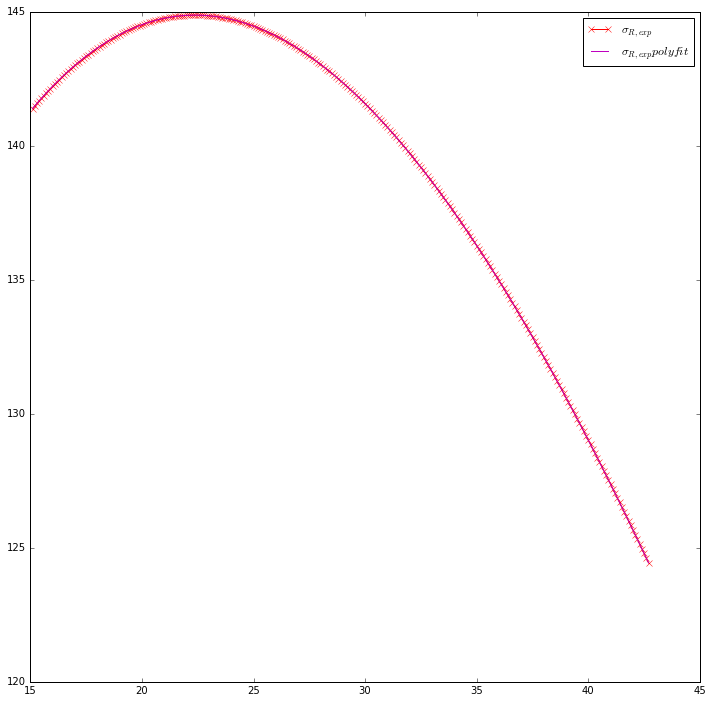

In [36]:
# sig_R_0 = 152.5
sig_R_0 = 107.5
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
plt.plot(points, [sigR_exp(R) for R in points], 'x-', color='red', label='$\sigma_{R, exp}$')
plt.plot(points, [poly_marj_R(R) for R in points], '-', color='m', label='$\sigma_{R, exp} polyfit$')
plt.legend()
plt.show()

Теперь нанесем туда же данные по газу:

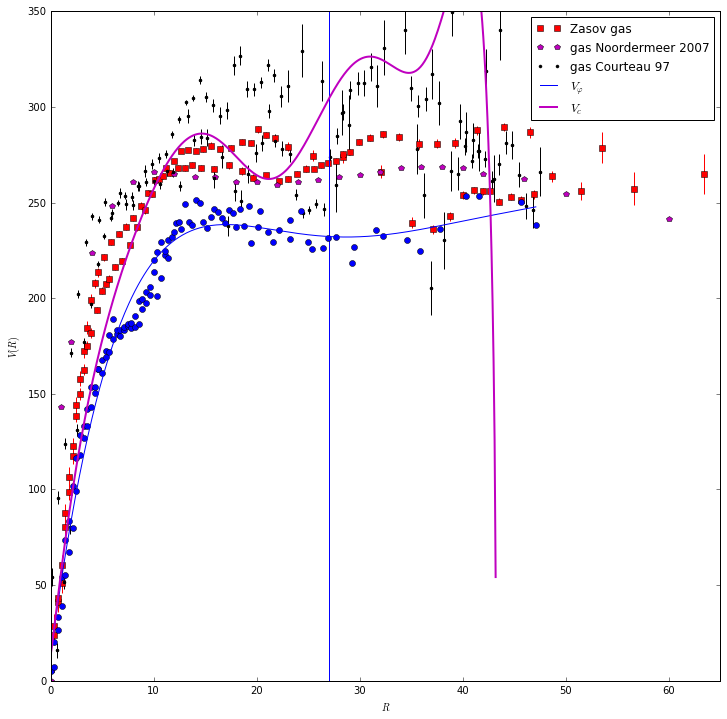

In [37]:
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='red')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
plt.plot(r_wsrt, [v*sin(incl * pi / 180) for v in vel_wsrt], 'p', label="gas Noordermeer 2007", color='m')
# plt.errorbar(r_wsrt, vel_wsrt, yerr=e_vel_wsrt, fmt='.', marker='.', mew=0, color='m')
plt.plot(r_c_b, vel_c_b, '.', label = 'gas Courteau 97', color='black')
plt.errorbar(r_c_b, vel_c_b, yerr=e_vel_c_b, fmt='.', marker='.', mew=0, color='black')

plt.axvline(x=27.)

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
plt.plot(test_points, [predict_gas(R) for R in test_points], 
         '-', color='m', label=r'$V_c$', lw=2.)
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V(R)$')
plt.ylim(0, 350)
plt.xlim(0, 65)
plt.legend()

Нарисуем несколько кривых еще, чтобы понимать: 

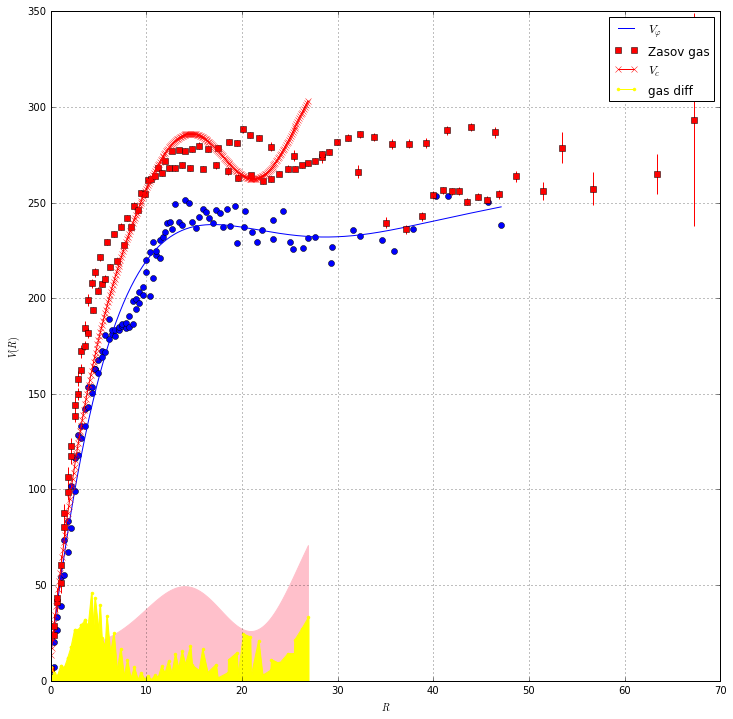

In [38]:
test_points_z = np.arange(0.0, 27., 0.1)

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='blue', label=r'$V_{\varphi}$')
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='red')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
ad = [sqrt(abs(asym_drift_value(R) + poly_star(R)**2)) for R in test_points_z]
plt.plot(test_points_z, ad, 
         'x-', color='red', label=r'$V_c$')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V(R)$')

dif = [(ad[i] - poly_star(test_points[i])) for i in range(test_points_z.__len__())]
# plt.plot(test_points_z, dif, marker='.', lw=1, color = 'pink', label = 'drift value')
plt.fill_between(test_points_z, 0, dif, color = 'pink')

cut = lambda l: l < 27.

dif2 = [abs(predict_gas(R) - vel_g_b[np.where(r_g_b==R)[0][0]]) for R in filter(cut, r_g_b)]
plt.plot(filter(cut, r_g_b), dif2, marker='.', lw=1, color = 'yellow', label = 'gas diff')
plt.fill_between(filter(cut, r_g_b), 0, dif2, color = 'yellow')

plt.grid()
plt.legend()
plt.show()

И посмотрим на разброс значений:

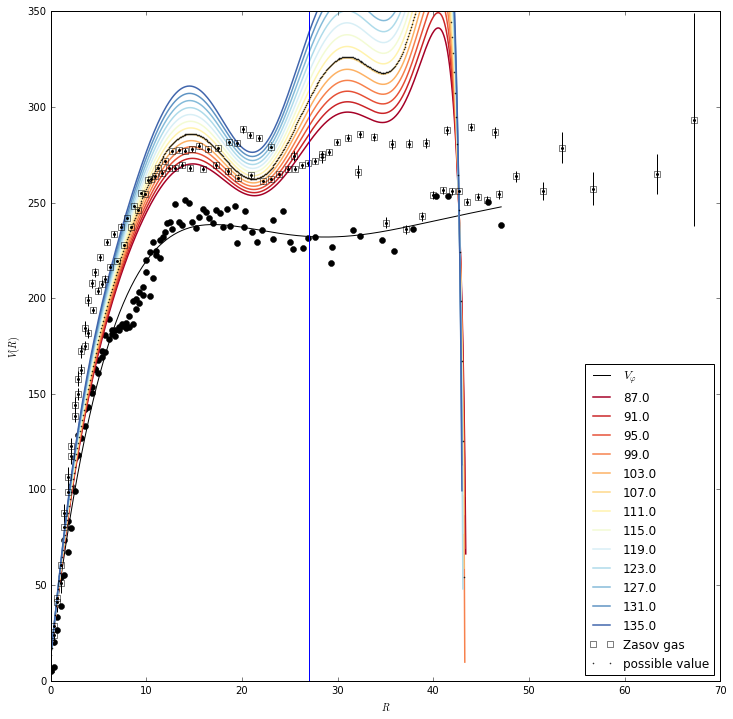

In [39]:
# sigmas = np.arange(112., 185., 4.)
sigmas = np.arange(87., 137., 4.)

plt.plot(r_ma_b, vel_ma_b, 'o', color='black', markersize=6)
plt.plot(test_points, poly_star(test_points), '-', color='black', label=r'$V_{\varphi}$')
plt.xlabel('$R$')
plt.ylabel('$V(R)$')
plt.ylim(0, 350)

for s in sigmas:
    sig_R_0 = s
    poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
    ind = np.where(sigmas==s)[0][0]
    plt.plot(test_points, [predict_gas(R) for R in test_points], 
     '-', label=('%s' % s), lw=1.5, ms=0.5, color=plt.cm.RdYlBu(ind*1.0/len(sigmas)))
    
plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='black', mfc='none')
plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='black')
    
# sig_R_0 = 140.
sig_R_0 = 107.5
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
plt.plot(test_points, [predict_gas(R) for R in test_points], 
     'o', label='possible value', color='black', mfc='none', markersize=1)

plt.axvline(x=27.)
plt.legend(loc='lower right')
plt.show()

Картинка для статьи <a id=ad></a>

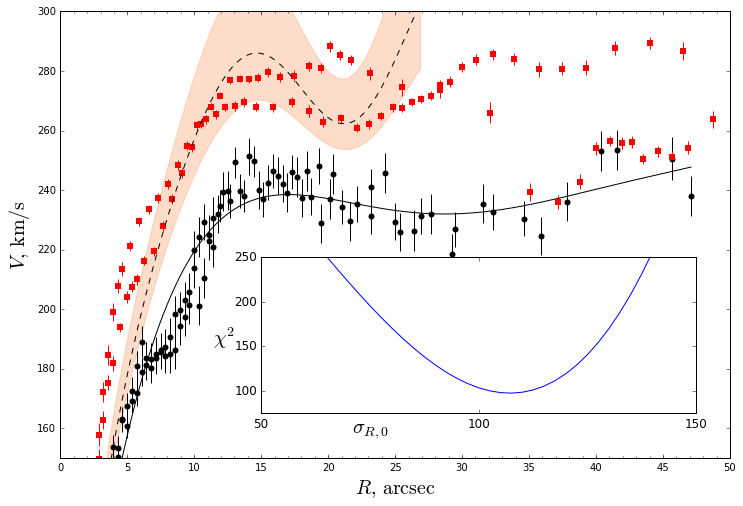

In [40]:
tex_imgs_dir = "C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"
try: 
    os.chdir(tex_imgs_dir)
except:
    tex_imgs_dir = "C:\\Users\\Alex March\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"

majorLocator   = MultipleLocator(5)
majorFormatter = FormatStrFormatter('%d')
minorLocator   = MultipleLocator(1)

os.chdir(tex_imgs_dir)

spl_min = spl_min1

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# sigmas = [112., 185.]
sigmas = [87., 137.]
test_points = np.arange(0.0, max(r_ma_b), 0.1)

ax.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='o', mew=0, color='black')
ax.plot(test_points, poly_star(test_points), '-', color='black', label=r'$V_{\varphi}$')

sig_R_0 = sigmas[0]
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
pg1 = [predict_gas(R) for R in test_points_z]
sig_R_0 = sigmas[1]
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
pg2 = [predict_gas(R) for R in test_points_z]

ax.fill_between(test_points_z, pg1, pg2, color=plt.cm.RdYlBu(0.5/len(sigmas)), alpha=0.3)

ax.errorbar(r_g_b[:-1], vel_g_b[:-1], yerr=e_vel_g_b[:-1], fmt='.', marker='s', mew=0, color='red')
    
# sig_R_0 = 152.5
sig_R_0 = 107.5
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
ax.plot(test_points_z, [predict_gas(R) for R in test_points_z], 
     '--', label='possible value', color='black', mfc='none', markersize=1)


rect = [0.3, 0.1, 0.65, 0.35]
ax1 = add_subplot_axes(ax,rect)

sigmas = np.arange(60.0, 250, 2.5)
ax1.plot(sigmas, drift_err, '-')
# ax1.set_ylim(0, 200)
ax1.set_ylim(75, 250)
# ax1.set_xlim(100, 200)
ax1.set_xlim(50, 150)
ax1.set_ylabel(r'$\chi^2$', rotation=0, fontsize=20)
ax1.yaxis.set_label_coords(-0.085, 0.4)
# ax1.set_xticks([100, 150, 200])
ax1.set_xticks([50, 100, 150])
ax1.set_xlabel(r'$\sigma_{R,0}$', fontsize=20)
ax1.xaxis.set_label_coords(0.25, -0.05)


# ax1.set_xlim(0, 27.)
# ad = [sqrt(abs(asym_drift_value(R) + poly_star(R)**2)) for R in test_points_z]
# dif = [abs(ad[i] - poly_star(test_points[i])) for i in range(test_points_z.__len__())]
# ax1.plot(test_points_z, dif, '-.', lw=1, color = 'black', label = 'gas diff')
# # ax1.fill_between(test_points_z, 0, dif, color = 'pink')
# dif2 = [abs(predict_gas(R) - vel_g_b[np.where(r_g_b==R)[0][0]]) for R in filter(cut, r_g_b)]
# ax1.plot(filter(cut, r_g_b), dif2, '+', color = 'black', label = 'gas diff')
# # ax1.fill_between(filter(cut, r_g_b), 0, dif2, color = 'yellow')
# ax1.set_yticks([25, 50])
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
ax.set_ylabel(r'$V,\, \rm{km/s}$', fontsize=20)
ax.set_ylim(150, 300)
ax.set_xlim(0, 50)

plt.savefig('ngc338_ad.ps', format='ps', orientation='landscape')
plt.savefig('ngc338_ad.png', format='png')
plt.savefig('ngc338_ad.pdf', format='pdf', dpi=150)
plt.show()

os.chdir("C:\\science\\2FInstability\\data\\ngc338")

Попробуем как и раньше восстановить итеррационно из ассиметричного сдвига:

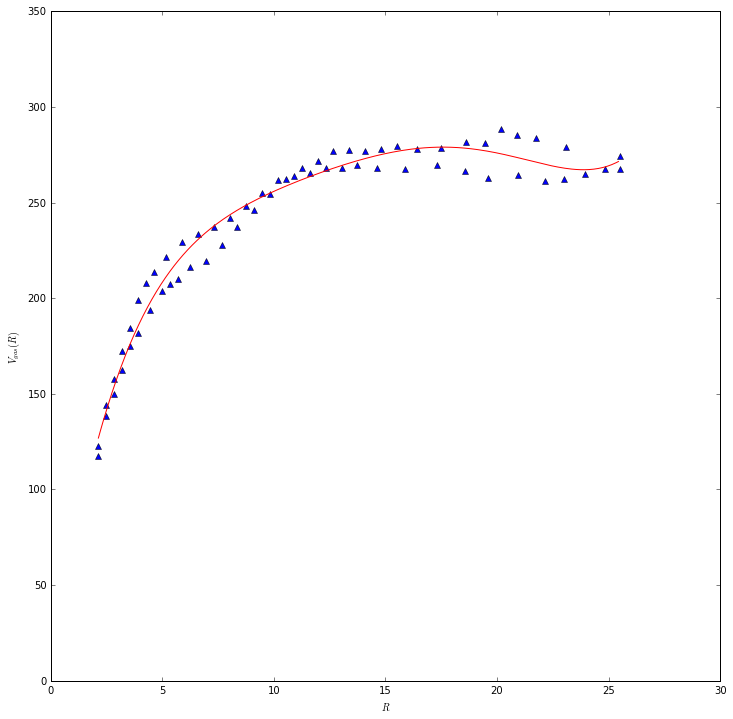

In [41]:
r_gas, v_gas, eg = zip(*gas_data_zasov)
poly_gas = poly1d(polyfit(r_gas, v_gas, deg=5))

plt.plot(r_gas, v_gas, '^', color='blue', markersize=6)
test_points = np.arange(min(r_gas), max(r_gas), 0.1)
plt.plot(test_points, poly_gas(test_points), '-', color='red')
plt.xlabel('$R$'); plt.ylim(0, 350)
plt.ylabel('$V_{gas}(R)$')
plt.show()

С полиномами к сожалению не получается, слишком уж у них производную колбасит. Возьмем как и раньше экспоненту: $\frac{\partial\ln\sigma_{R}^{2}}{\partial\ln R} = - \frac{2R}{h}$ 

In [42]:
def log_deriv(R, h):
#     return 2*R * p.deriv()(R) / p(R)
    return -2*R*h

AD_value = lambda l: poly_gas(l)**2 - poly_star(l)**2

def sig_R2_iter(R, h):
    return AD_value(R) / (sigPhi_to_sigR(R)**2 - 1 + R/h_d - log_deriv(R, h))

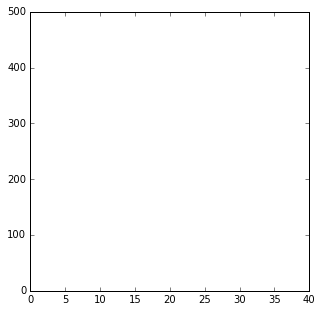

In [43]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(5,5))

ax.set_ylim([0., 500.])
ax.set_xlim([0, 40])

frame1, = ax.plot([], [], color="blue", lw=2)
frame2, = ax.plot([], [], color="red", lw=2)


def init():
    frame1.set_data([], [])
    frame2.set_data([], [])

h_kin = 1. / (2*h_d)
test_points = filter(lambda l : l>12 and l <35, test_points)
    
def update(n): 
    # n = frame counter
    global h_kin
    sigR_next = [sqrt(abs(sig_R2_iter(R, h_kin))) for R in test_points]
    poly_iter = poly1d(polyfit(test_points, np.log(sigR_next), deg=1))
    h_kin = poly_iter[1]
    
    frame1.set_data(test_points, sigR_next)
    frame2.set_data(test_points,  [exp(poly_iter(R)) for R in test_points])
    frame1.set_label('h=%.4f' % h_kin)
    ax.legend()

# anim = animation.FuncAnimation(fig, update, init_func=init, frames=100, blit=True)
# anim.save('ad_value.mp4', fps=5, writer="ffmpeg", codec="libx264")

# plt.close(fig)

In [44]:
from IPython.display import HTML
video = open("ad_value.mp4", "rb").read()
video_encoded = video.encode("base64")
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(video_tag)

Можно также вычислить профиль радиальной дисперсии, если AD разделить на скобку справа:

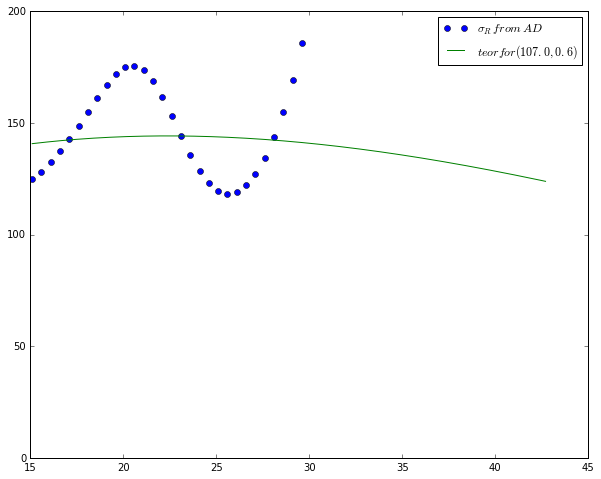

In [45]:
def log_deriv(R):
    return 2*R * poly_min_R.deriv()(R) / poly_min_R(R)

def sig_R2_iter(R):
    return AD_value(R) / (sigPhi_to_sigR(R)**2 - 1 + R/h_d - log_deriv(R))

fig = plt.figure(figsize=(10,8))
plt.plot(points[0:-1:5], [sqrt(abs(sig_R2_iter(R))) for R in points][0:-1:5], 'o', label = '$\sigma_R\, from\, AD$')
plt.ylim(0, 200)
sig_R_0=107.
alpha = 0.6
plt.plot(points, [sigR_exp(R) for R in points] , '-', label = '$teor for (%s, %s)$' % (sig_R_0, alpha))
plt.legend()
plt.show()

# Картинки для оценки наклонов

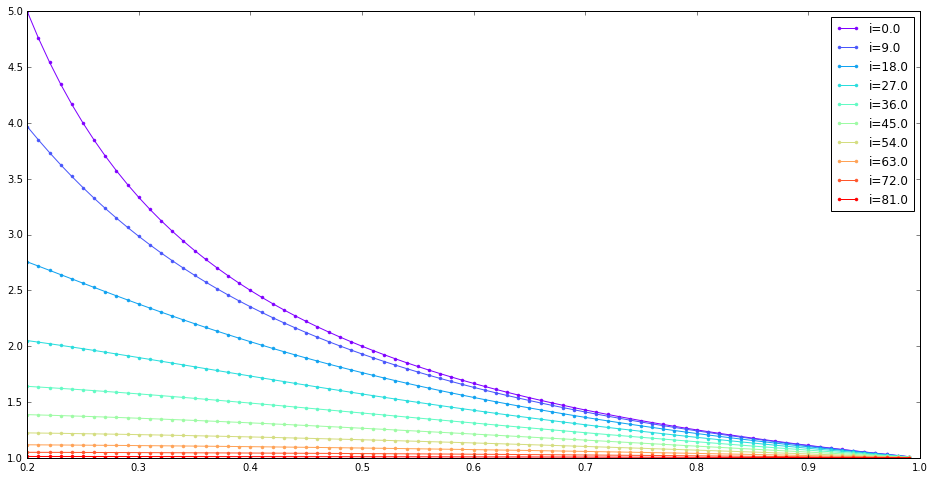

In [46]:
#Наклоны вдоль малой оси для разных значений угла
fig = plt.figure(figsize=(16,8))

def main_slice_i(l, i=0):
    return 1./sqrt(sin(i)**2 + cos(i)**2 * l**2) 

al_range = np.arange(0.2, 1., 0.01)
i_range = np.arange(0., np.pi/2, np.pi/20)

colors = cm.rainbow(np.linspace(0, 1, len(i_range)))
for i, cl  in zip(i_range, colors):
    plt.plot(al_range, map(lambda l: main_slice_i(l, i=i), al_range), '.-', color=cl, label='i={}'.format(i*180./np.pi))

plt.legend()
plt.show()

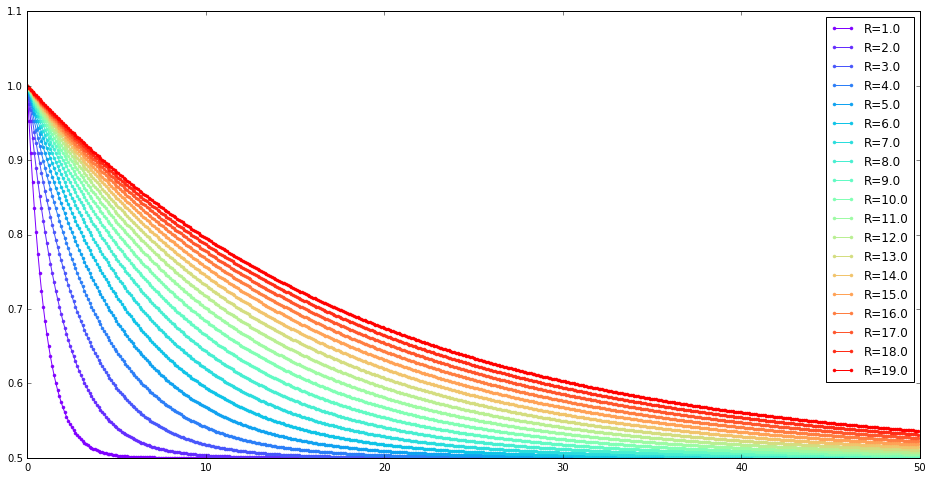

In [47]:
#Значения разных f
fig = plt.figure(figsize=(16,8))

rr = np.arange(0., 50., 0.1)
r_range = np.arange(1., 20., 1.)

colors = cm.rainbow(np.linspace(0, 1, len(r_range)))
for r, cl  in zip(r_range, colors):
    plt.plot(rr, map(lambda l: f(l, r), rr), '.-', color=cl, label='R={}'.format(r))

plt.legend()
plt.show()

Попробуем посчитать $\chi^2$ нормально по двум картам одновременно, т.е. 
$\chi^2 = \frac{N_1\times\chi_1^2 + N_2\times\chi_2^2}{N_1 + N_2}$

N1_maj=37,	 N2_min=16,	 chi^2_corr[0][0]=25.3432686377 (was 27.2591872135 and 24.5147633076)


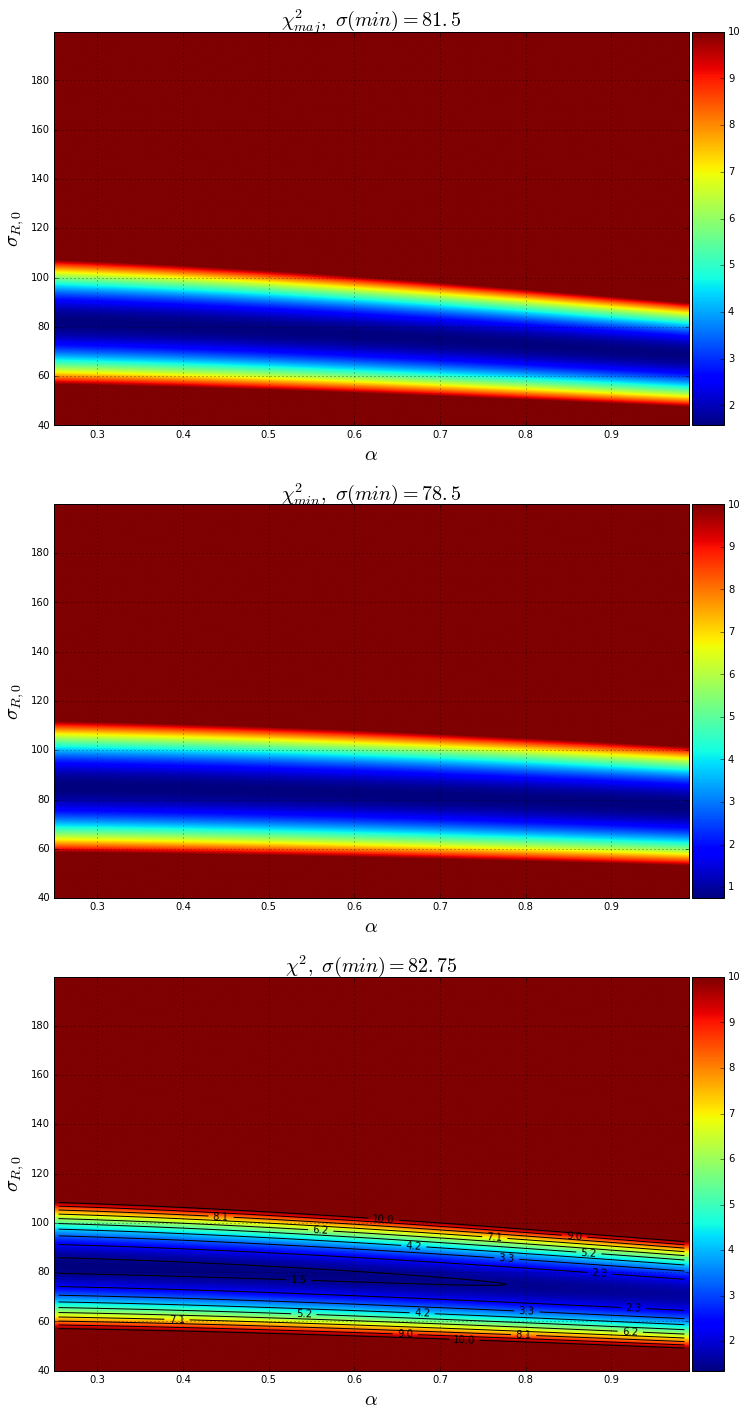

In [48]:
alphas = np.arange(0.25, 1., 0.01)
# sigmas = np.arange(100.0, 200, 0.25)
sigmas = np.arange(40.0, 200, 0.25)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[12,24])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=10.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=10.)
corr_image = (image_min*len(sig_min_p) + image_maj*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
print 'N1_maj={},\t N2_min={},\t chi^2_corr[0][0]={} (was {} and {})'.format(len(sig_maj_p), len(sig_min_p), corr_image[0][0], 
                                                                            image_min[0][0], image_maj[0][0])
plot_chi2_map(corr_image, axes[2], log_scale=False, title='$\chi^2$', is_contour=True, vmax=10.)
plt.show()

# Monte-Carlo

In [49]:
import scipy.optimize as opt

def chisqfunc((x_sig, x_alpha)):
    global sig_R_0, alpha
    sig_R_0 = x_sig
    alpha = x_alpha
    sqerr_ma = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    sqerr_mi = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
    chisq = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
    return chisq

x0 = np.array([100., 0.5])

res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
print res

      fun: 1.3502169235669557
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.95399252e-06,   9.02661279e-02])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 3
   status: 0
  success: True
        x: array([ 82.62970558,   0.25      ])


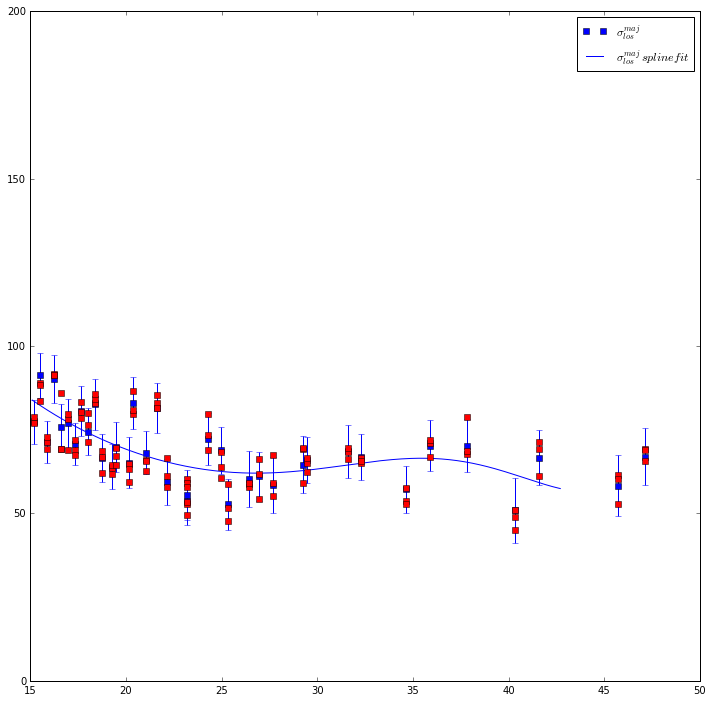

In [50]:
def gen_next_normal(radii, sig, esig):
    randomDelta =  np.array([np.random.normal(0., derr/2, 1)[0] for derr in esig] ) 
    randomdataY = sig + randomDelta
    return zip(radii, randomdataY)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
 
for i in range(3):
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    plt.plot(r, s, 's', color='red')

plt.ylim(0., 200.)
plt.legend()
plt.show()

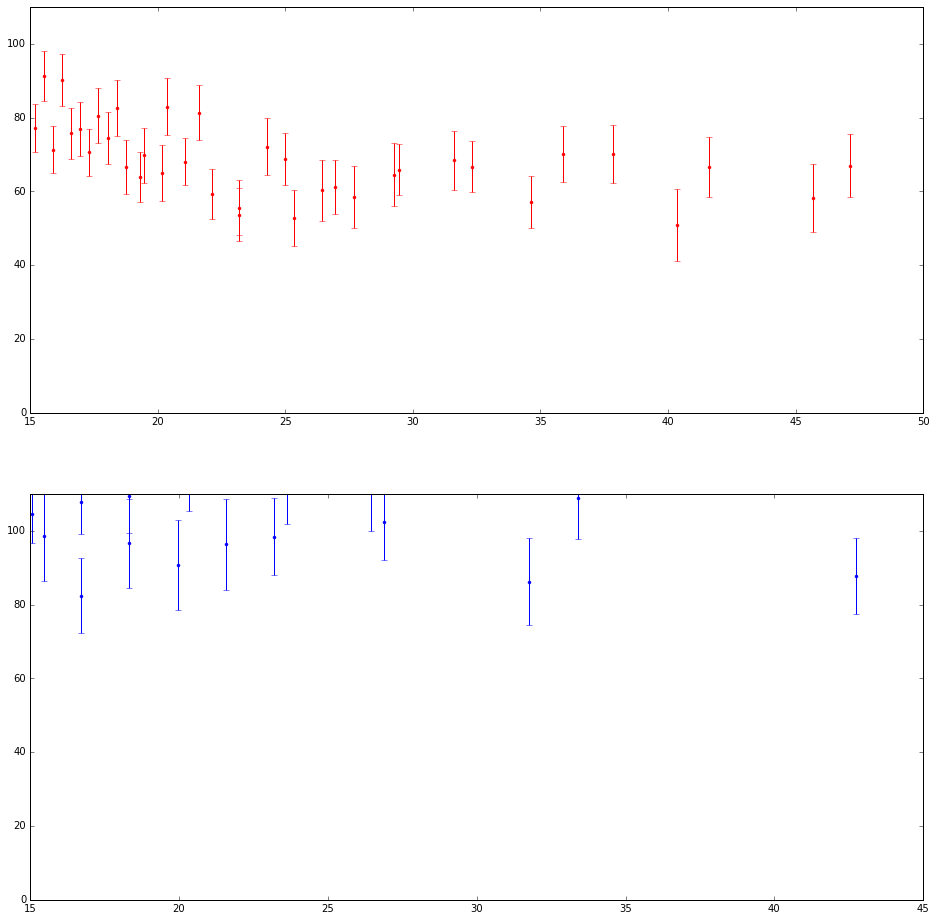

In [51]:
import time
os.chdir("C:\\science\\2FInstability\\data\\ngc338")

N = 1000

result = []
start_time = time.time()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

radii_maj1, sig_maj_p1, e_sig_maj_p1 = radii_maj, sig_maj_p, e_sig_maj_p
radii_min1, sig_min_p1, e_sig_min_p1 = radii_min, sig_min_p, e_sig_min_p

if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'monte_carlo.npy'):
    result = np.load(pics_path + "monte_carlo.npy")
else:
    for i in log_progress(range(N)):
        global spl_maj, spl_min
        global radii_min, radii_maj, sig_min_p, sig_maj_p, sig_min_0
        
        r, s = zip(*gen_next_normal(radii_maj1, sig_maj_p1, e_sig_maj_p1))
        spl_maj = inter.UnivariateSpline(r[1:], s[1:], k=3, s=10000.)
        
        radii_maj, sig_maj_p = r, s
        
        ax1.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
        
        r, s = zip(*gen_next_normal(radii_min1, sig_min_p1, e_sig_min_p1))
        spl_min = inter.UnivariateSpline(r[1:], s[1:], k=3, s=10000.)
        sig_min_0 = spl_min(radii_min[0])
        
        radii_min, sig_min_p = r, s
        
        ax2.plot(points, spl_min(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='red')
        
        res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
        result.append(res.x)
    np.save(pics_path + 'monte_carlo', np.array(result))
    print("--- %s seconds ---" % (time.time() - start_time))
    
ax1.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='red')
ax2.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='o', marker='.', color='blue')    
ax1.set_ylim(0., 110.)
ax2.set_ylim(0., 110.)
plt.show()


radii_maj, sig_maj_p, e_sig_maj_p = radii_maj1, sig_maj_p1, e_sig_maj_p1
radii_min, sig_min_p, e_sig_min_p = radii_min1, sig_min_p1, e_sig_min_p1

In [52]:
len(result)

1000

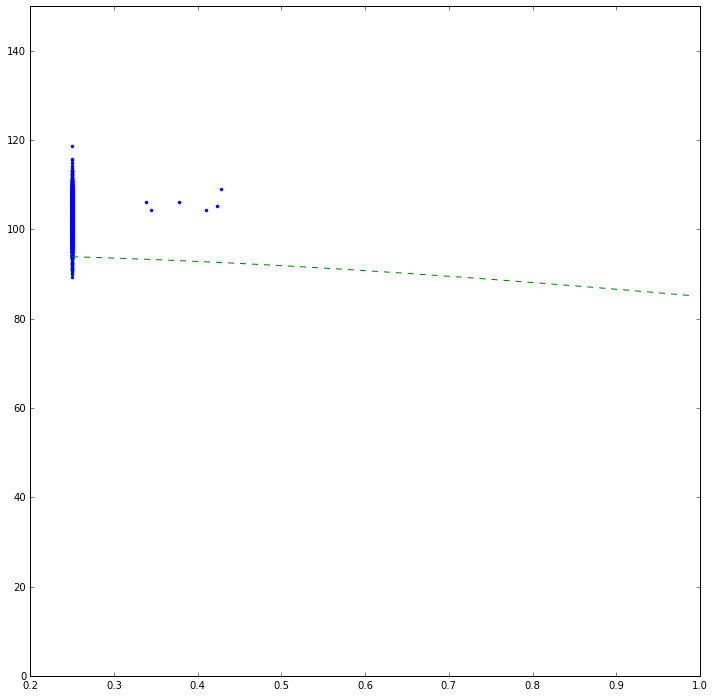

In [53]:
sig_min_0 = 85

s,a = zip(*result)
plt.plot(a, s, '.')
plt.plot(alphas, map(main_slice, alphas), '--')
# plt.xlim(0.0, 0.99)
plt.ylim(0, 150)
plt.show()

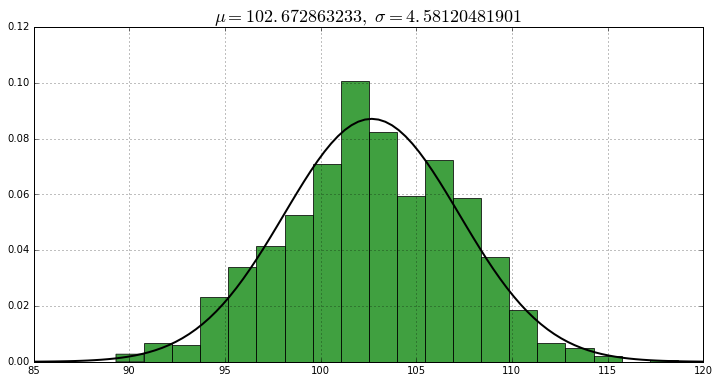

In [54]:
from scipy.stats import norm

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(s, 20, normed=1, facecolor='green', alpha=0.75)
mu, std = norm.fit(s)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

ax.set_title('$\mu=%s,\ \sigma=%s$' % (mu, std), fontsize=18)
ax.grid(True)

plt.show()

In [55]:
min_n = len(radii_maj)

def func(x, alph, sig):
    global alpha, sig_R_0
    alpha = alph
    sig_R_0 = sig
    return [sig_min_exp(x[l]) if l > min_n else sig_maj_exp(x[l]) for l in range(len(x))]

In [56]:
rr = radii_maj + radii_min
print len(rr), min_n
sgs = sig_maj_p + sig_min_p
esgs = e_sig_maj_p + e_sig_min_p
esgs = [l/2 for l in esgs]

53 37


In [57]:
popt, pcov = opt.curve_fit(func, rr, sgs, sigma=esgs, absolute_sigma=True)
print popt, pcov

s_sq = np.array([((np.array(func(rr, popt[0], popt[1]))-np.array(sgs))**2)[l]/esgs[l]**2 for l 
                 in range(len(rr))]).sum()/(len(rr)-2)
pcov = pcov * s_sq
for i in range(len(pcov)):
    print sqrt(pcov[i][i])

[ -5.48974440e-05   9.45494482e+01] [[  3.61814888e+04  -3.11209948e+02]
 [ -3.11209948e+02   3.14620350e+00]]
499.254774444
4.65556522468


In [58]:
def err_pcov(popt, pcov):
    s_sq = np.array([((np.array(func(rr, popt[0], popt[1]))-np.array(sgs))**2)[l]
                     /esgs[l]**2 for l in range(len(rr))]).sum()/(len(rr)-2)
    pcov = pcov * s_sq
    return (sqrt(pcov[0][0]), sqrt(pcov[1][1]))

In [59]:
import time
os.chdir("C:\\science\\2FInstability\\data\\ngc1068")

N = 100

result1 = []
start_time = time.time()

for i in log_progress(range(N)):
    global spl_maj, spl_min
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    r1, s1 = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
    rr = r + r1
    sgs = s + s1
    
    global sig_min_0
    spl_min = inter.UnivariateSpline(r1[1:], s1[1:], k=3, s=10000.)
    sig_min_0 = spl_min(radii_min[0])

    popt, pcov = opt.curve_fit(func, rr, sgs, sigma=e_sig_maj_p+e_sig_min_p, absolute_sigma=True)

    err = err_pcov(popt, pcov)
    result1.append((popt[0], popt[1], err[0], err[1]))
print("--- %s seconds ---" % (time.time() - start_time))

--- 52.1570000648 seconds ---


C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


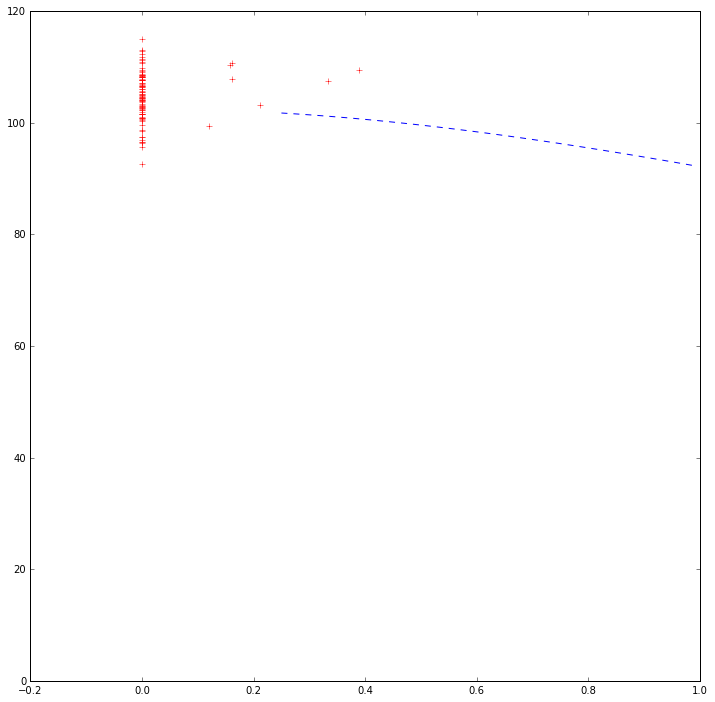

In [60]:
a,s,erra,errs = zip(*result1)
# plt.plot(a, s, '.')
# plt.errorbar(a, s, yerr=errs, xerr=erra, fmt='o', marker='.', color='red')
plt.plot(a, s, '+', color='red')
plt.plot(alphas, map(main_slice, alphas), '--')
# plt.xlim(0.0, 0.99)
plt.ylim(0, 120)
plt.show()

# Exponent on the edge

Возьмем прямой участок и подгоним экспонентами: 
$$\sigma_R = \sigma_{R,0}e^{-R/h}$$ $$\sigma_Z = \sigma_{Z,0}e^{-R/h}$$

In [61]:
def fuu(x, A, B):
    return A*x + B

A,B = curve_fit(fuu, radii_min[-5:], map(np.log, sig_min_p[-5:]))[0]
print A,B

-0.0115909061365 4.96818202549


In [62]:
def fuu1(x, A, B):
    return np.exp(A*x+B)

86.27


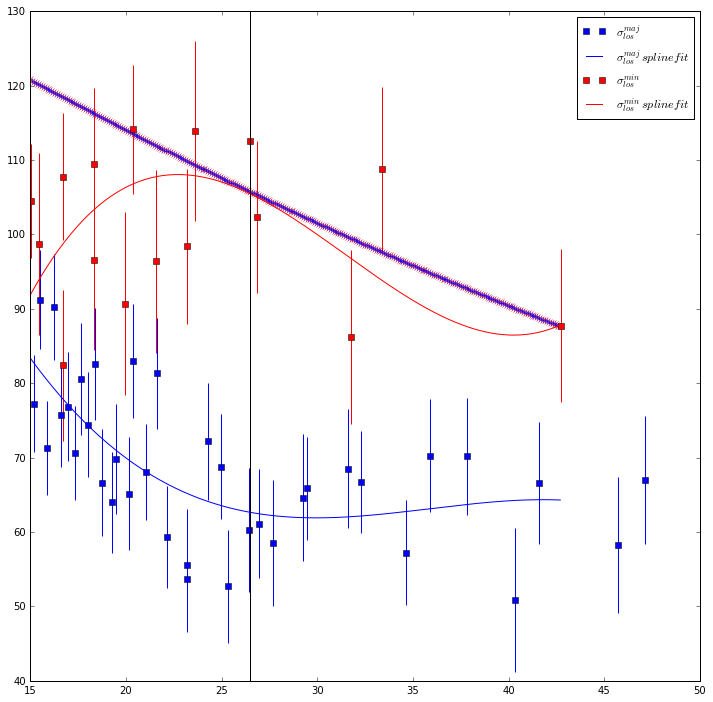

In [63]:
h_kin = float("{0:.2f}".format(-1./A))
print h_kin

points = np.arange(r_eb, max(radii_min), 0.1)

plt.plot(points, fuu1(points, A, B), 'x', color='red')
plt.plot(points, map(lambda l: np.exp(B)*np.exp(-l/h_kin), points), '+')

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min}\, splinefit$', color='red')
plt.axvline(x=radii_min[-5], color='black')
plt.legend()
plt.show()

In [64]:
sig_min_0 = fuu1(radii_min[-5], A, B)

def sigR_ger_exp(R):
    return sig_R_0*exp(-R/h_kin)/exp(-radii_min[-5]/h_kin)

def sigZ_ger_exp(R):
    return sigR_ger_exp(R)*alpha

def sig_maj_exp(R):
    return sqrt(sigPhi_to_sigR_real(R) * sigR_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

def sig_min_exp(R):
    return sqrt(sigR_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

In [65]:
alpha = 0.25
sig_R_0 = main_slice(alpha)
print sig_min_exp(0.0), fuu1(0.0, A, B)

143.767604358 143.765288023


In [66]:
alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(40.0, 200, 0.25)


radii_maj1, sig_maj_p1, e_sig_maj_p1 = radii_maj, sig_maj_p, e_sig_maj_p
radii_min1, sig_min_p1, e_sig_min_p1 = radii_min, sig_min_p, e_sig_min_p

sig_maj_data = zip(radii_maj, sig_maj_p, e_sig_maj_p)
sig_maj_data = filter(lambda l: l[0] > radii_min[-5], sig_maj_data)
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 
radii_min, sig_min_p, e_sig_min_p = radii_min[-5:], sig_min_p[-5:], e_sig_min_p[-5:]

image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)

radii_maj, sig_maj_p, e_sig_maj_p = radii_maj1, sig_maj_p1, e_sig_maj_p1
radii_min, sig_min_p, e_sig_min_p = radii_min1, sig_min_p1, e_sig_min_p1

N1_maj=37,	 N2_min=16,	 chi^2_corr[0][0]=28.4240514292 (was 35.3814587489 and 25.4154428585)


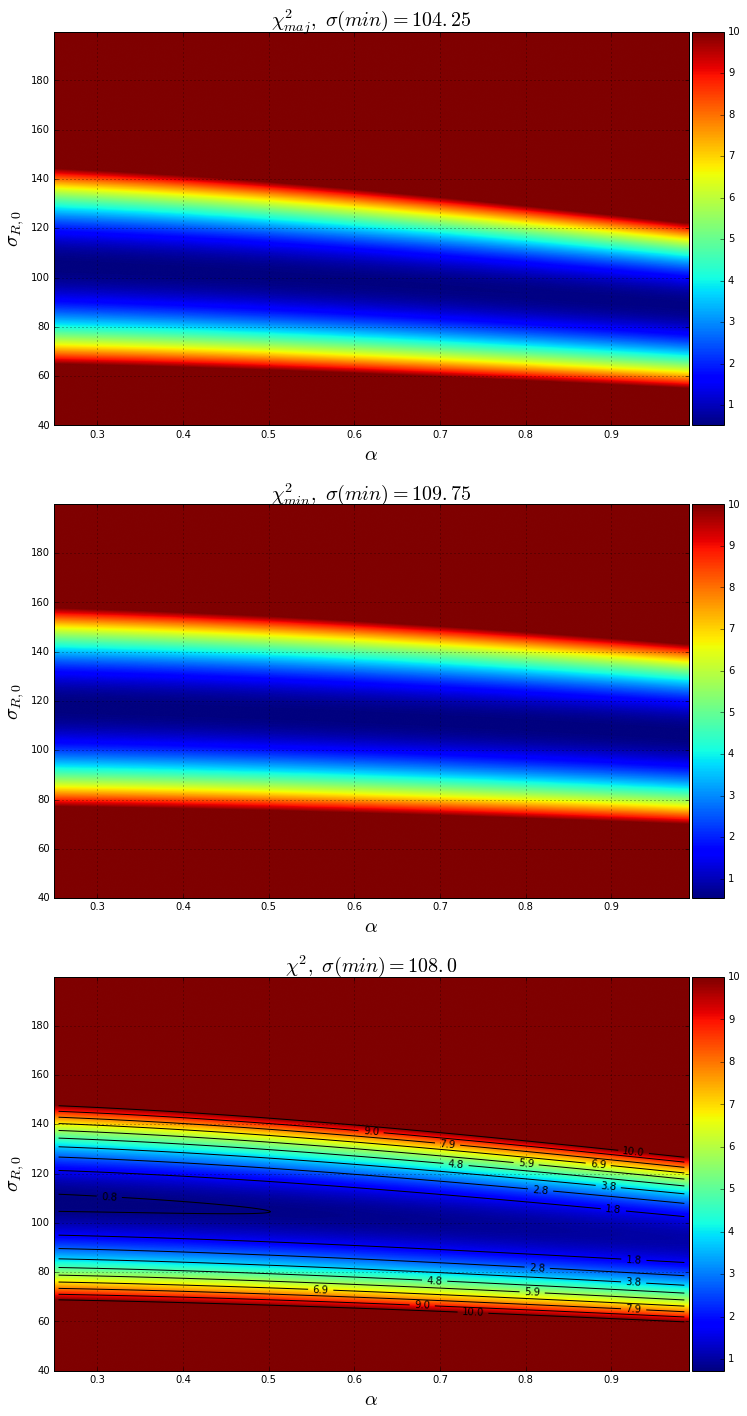

In [67]:
alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(40.0, 200, 0.25)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[12,24])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=10.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=10.)
corr_image = (image_min*len(sig_min_p) + image_maj*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
print 'N1_maj={},\t N2_min={},\t chi^2_corr[0][0]={} (was {} and {})'.format(len(sig_maj_p), len(sig_min_p), corr_image[0][0], 
                                                                            image_min[0][0], image_maj[0][0])
plot_chi2_map(corr_image, axes[2], log_scale=False, title='$\chi^2$', is_contour=True, vmax=10.)
plt.show()

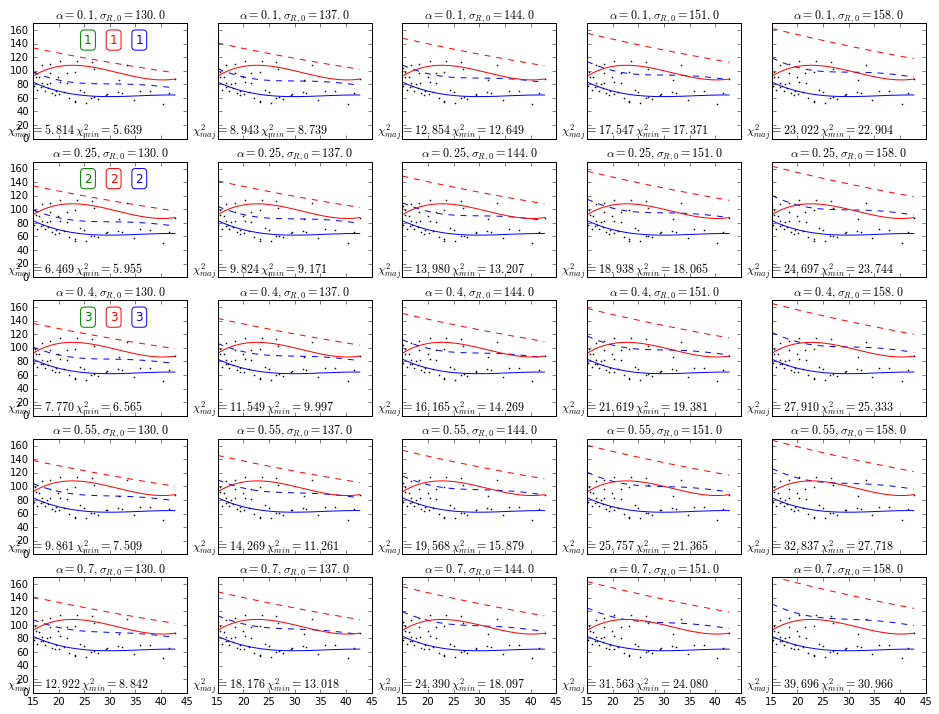

In [68]:
alphas = np.arange(0.1, 0.85, 0.15)
sigmas = np.arange(130., 165., 7.)

plot_ranges(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

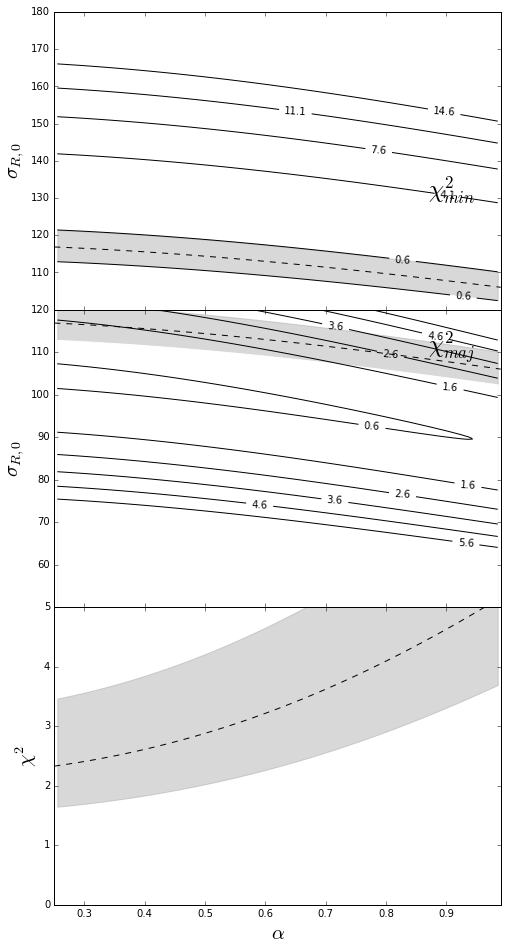

In [69]:
alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(40.0, 200, 0.25)

import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
levels = np.linspace(start=image_min.min()*1.2, stop=image_min.min()*1.1+14, num=5)

cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()

v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{min}$', size = 24.)
ax.text(0.87, 130, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.set_ylim(100, 180)
# ax.set_ylim(40, 200)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')

ax = axes[1]
# levels = np.append(np.linspace(start=image_maj.min()+0.1, stop=image_maj.min()+4.1, num=6), np.array([image_maj.min()+0.25]))
levels = np.linspace(start=image_maj.min()*1.1, stop=image_maj.min()*1.1+5, num=6)
# levels = [image_maj.min()+0.1, image_maj.min()+0.25, image_maj.min()+1.1, image_maj.min()+2.1, image_maj.min()+3.1, 
#           image_maj.min()+4.1]
levels = sorted(levels)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{maj}$', size = 24.)
ax.text(0.87, 110, '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')

ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
ax.set_ylim(120, 200)
ax.set_ylim(50, 120)

ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)


import scipy.interpolate as sp
try:
    f1 = sp.interp1d(x2, err_maj1, kind='linear')
    ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
except Exception:
    f2 = sp.interp1d(x1, err_maj2, kind='linear')
    ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)

ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

ax.set_ylim(0., 5.)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.25, 0.99)

# plt.savefig('ngc338_maps.eps', format='eps')
# plt.savefig('ngc338_maps.png', format='png')
# plt.savefig('ngc338_maps.pdf', format='pdf', dpi=150)

plt.show()

In [70]:
sig_maj_data = zip(radii_maj, sig_maj_p, e_sig_maj_p)
sig_maj_data = filter(lambda l: l[0] > radii_min[-5], sig_maj_data)
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 
radii_min, sig_min_p, e_sig_min_p = radii_min[-5:], sig_min_p[-5:], e_sig_min_p[-5:]

--- 3.29200005531 seconds ---


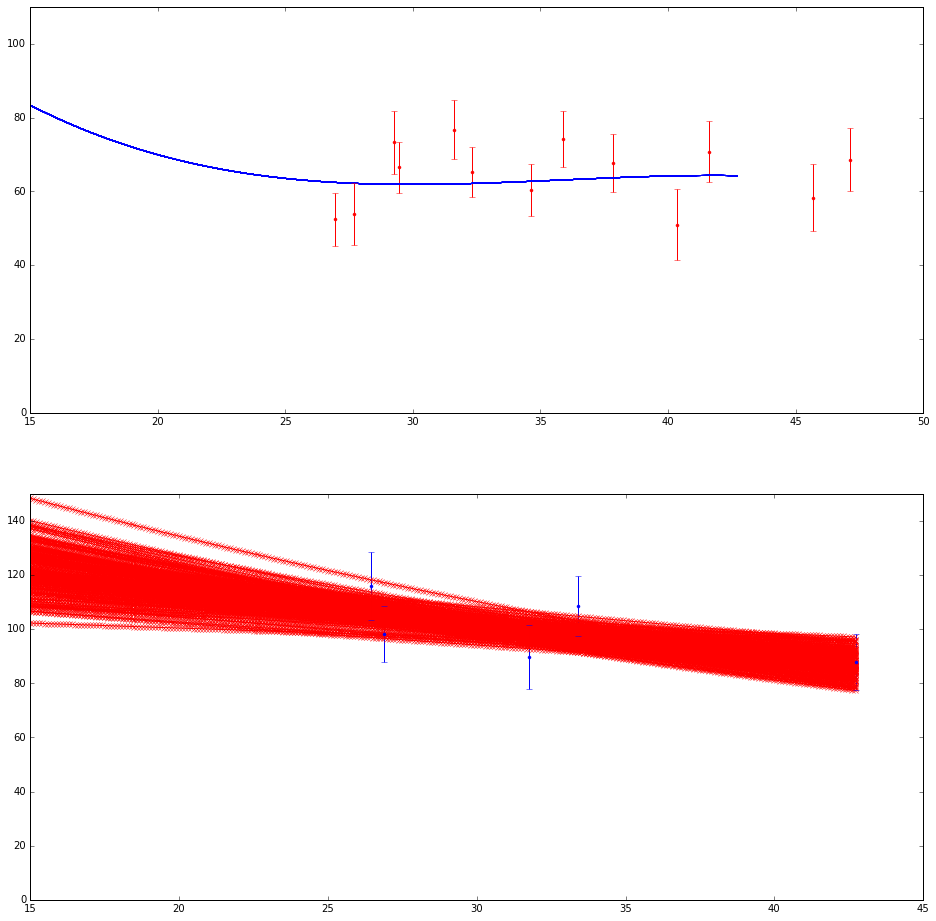

In [71]:
import time
os.chdir("C:\\science\\2FInstability\\data\\ngc338")

N = 100

result = []
start_time = time.time()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

radii_maj1, sig_maj_p1, e_sig_maj_p1 = radii_maj, sig_maj_p, e_sig_maj_p
radii_min1, sig_min_p1, e_sig_min_p1 = radii_min, sig_min_p, e_sig_min_p

for i in log_progress(range(N)):
    global radii_min, radii_maj, sig_min_p, sig_maj_p
    global A,B,h_kin

    r, s = zip(*gen_next_normal(radii_maj1, sig_maj_p1, e_sig_maj_p1))
    radii_maj, sig_maj_p = r, s

    ax1.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')

    r, s = zip(*gen_next_normal(radii_min1, sig_min_p1, e_sig_min_p1))
    A, B = curve_fit(fuu, r, map(np.log, s))[0]
#     print A,B
    h_kin = float("{0:.2f}".format(-1./A))
#     print h_kin
    radii_min, sig_min_p = r, s

    ax2.plot(points, map(lambda l: np.exp(B)*np.exp(-l/h_kin), points), '-', color='red')
    ax2.plot(points, fuu1(points, A, B), 'x', color='red')

    res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
    result.append(res.x)
print("--- %s seconds ---" % (time.time() - start_time))
    
ax1.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='red')
ax2.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='o', marker='.', color='blue')    
ax1.set_ylim(0., 110.)
ax2.set_ylim(0., 150.)
plt.show()

radii_maj, sig_maj_p, e_sig_maj_p = radii_maj1, sig_maj_p1, e_sig_maj_p1
radii_min, sig_min_p, e_sig_min_p = radii_min1, sig_min_p1, e_sig_min_p1

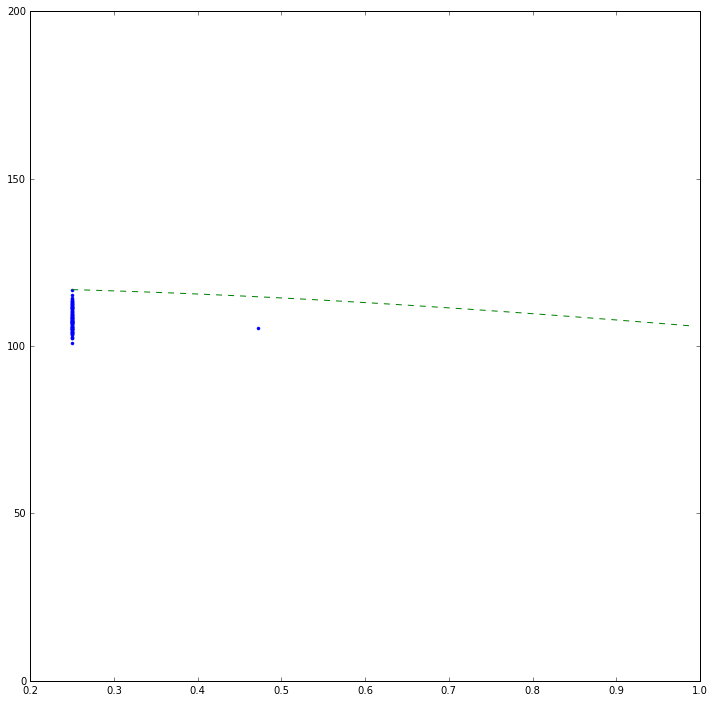

In [72]:
s,a = zip(*result)
plt.plot(a, s, '.')
plt.plot(alphas, map(main_slice, alphas), '--')
# plt.xlim(0.0, 0.99)
plt.ylim(0, 200)
plt.show()

# Картинки для статьи
[Перейти сразу к карте](#map)

In [73]:
tex_imgs_dir = "C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"
try: 
    os.chdir(tex_imgs_dir)
except:
    tex_imgs_dir = "C:\\Users\\Alex March\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"

In [74]:
# os.chdir(tex_imgs_dir)

sig_maj_data_t = zip(r_ma, sig_ma, e_sig_ma)
sig_maj_data_t = map(bind_curve, sig_maj_data_t)
sig_maj_data_t.sort()
radii_maj_t, sig_maj_p_t, e_sig_maj_p_t = zip(*sig_maj_data_t) 
sig_min_data_t = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data_t = map(bind_curve, sig_min_data_t)
sig_min_data_t.sort()
radii_min_t, sig_min_p_t, e_sig_min_p_t = zip(*sig_min_data_t) 


points = np.arange(r_eb, max(radii_min), 0.1)

def plot_n338_svelos(ax):    
#     fig = plt.figure(figsize=(8,8))
    # plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p,
#         label='$\sigma_{los}^{maj}$', fmt='.', marker='s', mew=1, color='blue')
    ax.plot(points, spl_maj(points), '--', color='black', lw=1.5)
    # plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p,
#         label='$\sigma_{los}^{min}$', fmt='.', marker='o', mew=1, color='red')
    ax.plot(points, spl_min(points), '-', color='black', lw=1.5)

    ax.errorbar(radii_maj_t, sig_maj_p_t, yerr=e_sig_maj_p_t,  
                 label=r'$\sigma_{\rm{los}}^{\rm{maj}}$', fmt='.', marker='s', markersize=3.5, mew=1, color='blue')
    ax.errorbar(radii_min_t, sig_min_p_t, yerr=e_sig_min_p_t, 
                 label=r'$\sigma_{\rm{los}}^{\rm{min}}$', fmt='.', marker='o', markersize=3.5, mew=1, color='red')
    ax.axvline(x=r_eb, color='black', ls='--')
#     lg = ax.legend(numpoints=1, fontsize=18)
#     lg.draw_frame(False)
#     ax.set_xlabel(r'$R,\,\rm{arcsec}$', fontsize=20)
#     ax.set_ylabel(r'$\sigma,\,\rm{km/s}$', fontsize=20)
    ax.set_ylim(0, 180)
    
# plot_n338_svelos(plt.subplot(111))
# # plt.savefig('ngc338_svedata.eps', format='eps')
# # plt.savefig('ngc338_svedata.png', format='png')
# # plt.show()

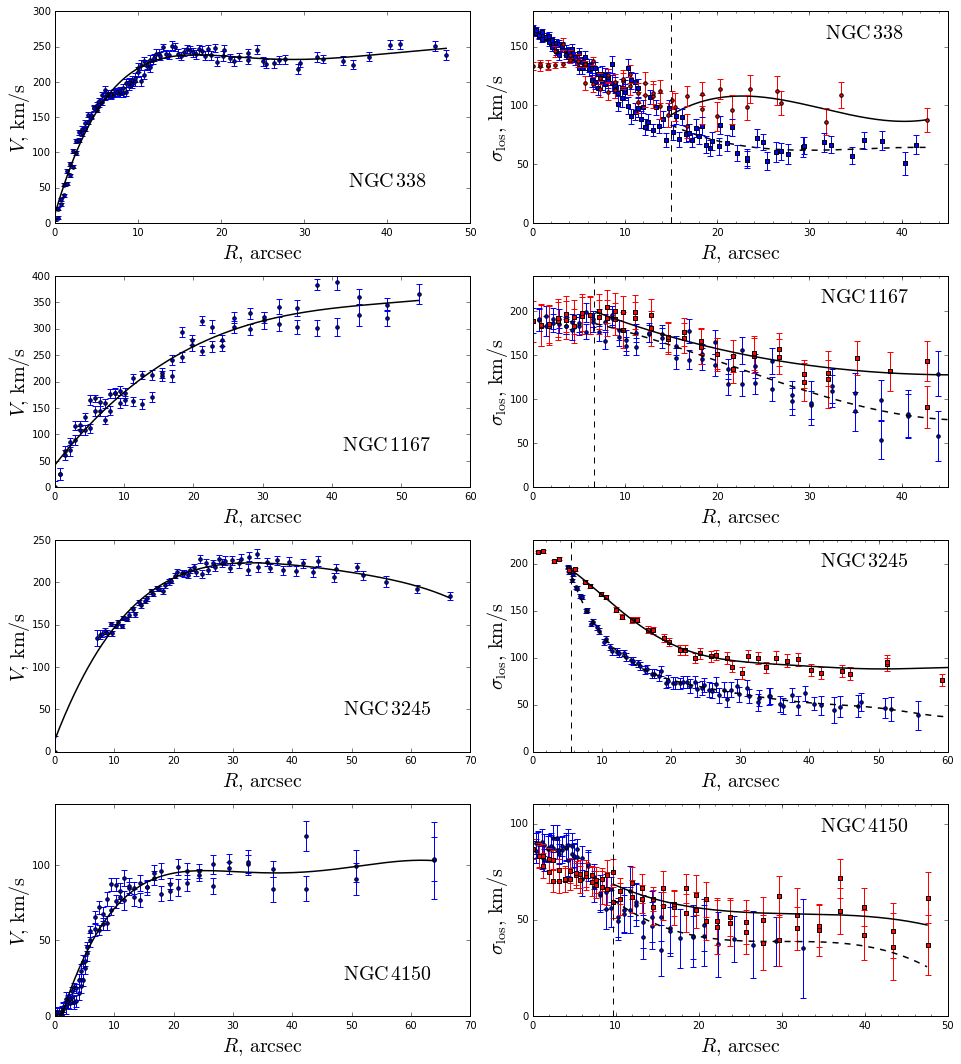

In [75]:
os.chdir(tex_imgs_dir)
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=[16,18])

ind = 0
names  = [r'$\rm{NGC\, 338}$', r'$\rm{NGC\, 1167}$', r'$\rm{NGC\, 3245}$', r'$\rm{NGC\, 4150}$']

ax1 = axs[0,0]
ax2 = axs[1,0]
ax3 = axs[2,0]
ax4 = axs[3,0]

axes = [ax1, ax2, ax3, ax4]


for name in ['n338', 'n1167', 'n3245', 'n4150']:
    ax = axes[ind]
    if name == 'n338':
        ax.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        tps = np.arange(0.0, max(r_ma_b), 0.1)
        ax.plot(tps, poly_star(tps), '-', color='black', lw=1.5)  
    else:
        a,b,c = zip(*np.load(name + '_maj_rot.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b = zip(*np.load(name + '_rot_poly.npy'))
        ax.plot(a,b, '-', color='black', lw=1.5) 
    ax.text(0.8, 0.2, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ax.yaxis.set_label_coords(-0.055, 0.5)
    ax.set_ylabel(r'$V,\, \rm{km/s}$', fontsize=20)
    ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ax.set_ylim(0)
    ax.xaxis.set_major_locator(MultipleLocator(10))
#     ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ind += 1
    
ax2.set_ylim(0, 400)

ind = 0
rebs = [r_eb, 6.7, 5.5, np.power(10, 2.81)/(13.74*10**6)*180*60*60/np.pi]
names  = [r'$\rm{NGC\, 338}$', r'$\rm{NGC\, 1167}$', r'$\rm{NGC\, 3245}$', r'$\rm{NGC\, 4150}$']

ax1 = axs[0,1]
ax2 = axs[1,1]
ax3 = axs[2,1]
ax4 = axs[3,1]

axes = [ax1, ax2, ax3, ax4]

plot_n338_svelos(ax1)

for name in ['n338', 'n1167', 'n3245', 'n4150']:
    ax = axes[ind]
    reb = rebs[ind]
    if name != 'n338':
        a,b,c = zip(*np.load(name + '_maj.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b,c = zip(*np.load(name + '_min.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='s', markersize=3.5, mew=1, color='red')
        a,b = zip(*np.load(name + '_maj_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ax.plot(a,b, '--', color='black', lw=1.5)
        a,b = zip(*np.load(name + '_min_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ax.plot(a,b, '-', color='black', lw=1.5)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
#     ax.plot([reb, reb],[0, (50 - 30*(ind/2))], color='black', lw=2)
    ax.axvline(x=reb, ls='--', color='black')
    ax.text(0.8, 0.9, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ax.yaxis.set_label_coords(-0.055, 0.5)
    ax.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=20)
    ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ind += 1

ax1.set_xlim(0, 45)
ax1.set_ylim(0)    

ax2.set_ylim(0, 240)
ax2.set_xlim(0, 45)
# ax2.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=15)

ax3.set_ylim(0, 225)
ax3.set_xlim(0, 60)
# ax3.axes.yaxis.set_ticklabels([])

# ax4.set_ylim(0, 150)
# ax4.set_xlim(0, 72)
# ax4.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=10)
# ax4.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=15)

ax4.set_ylim(0, 110)
# ax5.set_xlim(0, 50)
# ax5.axes.yaxis.set_ticklabels([])
# ax5.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=20)
# ax5.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)


fig.subplots_adjust(wspace=0.15, hspace=0.25)
# plt.savefig('observ_data.eps', format='eps')
# plt.savefig('observ_data.png', format='png')
# plt.savefig('observ_data.pdf', format='pdf', dpi=150)
plt.show()

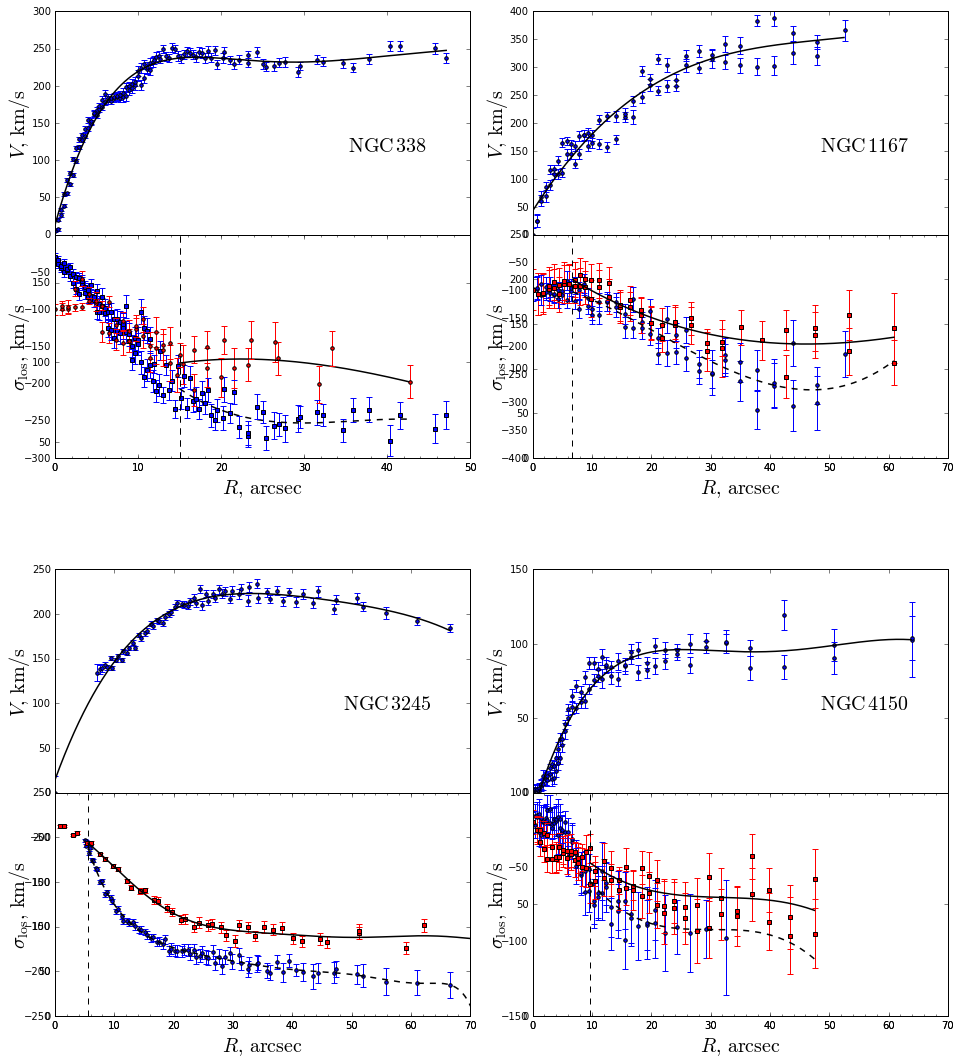

In [129]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

os.chdir(tex_imgs_dir)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[16,18])

ind = 0
names  = [r'$\rm{NGC\, 338}$', r'$\rm{NGC\, 1167}$', r'$\rm{NGC\, 3245}$', r'$\rm{NGC\, 4150}$']
fnames = ['n338', 'n1167', 'n3245', 'n4150']
rebs = [r_eb, 6.7, 5.5, np.power(10, 2.81)/(13.74*10**6)*180*60*60/np.pi]

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

axes = [ax1, ax2, ax3, ax4]
ins_axes = []

for ind, ax in enumerate(axes):
    name = fnames[ind]
    if name == 'n338':
        ax.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        tps = np.arange(0.0, max(r_ma_b), 0.1)
        ax.plot(tps, poly_star(tps), '-', color='black', lw=1.5)  
    else:
        a,b,c = zip(*np.load(name + '_maj_rot.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b = zip(*np.load(name + '_rot_poly.npy'))
        ax.plot(a,b, '-', color='black', lw=1.5) 
    ax.text(0.8, 0.7, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ax.yaxis.set_label_coords(-0.055, 0.5)
    ax.set_ylabel(r'$V,\, \rm{km/s}$', fontsize=20)
    ax.yaxis.set_label_coords(-0.055, 0.75)
    ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ax.set_ylim(0)
    ax.xaxis.set_major_locator(MultipleLocator(10))
#     ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(50))

    ins = inset_axes(ax, width="100%", height='50%', loc=3, borderpad=0.0)
    ins_axes.append(ins)
    reb = rebs[ind]
    if name != 'n338':
        a,b,c = zip(*np.load(name + '_maj.npy'))
        ins.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b,c = zip(*np.load(name + '_min.npy'))
        ins.errorbar(a, b, yerr=c, fmt='.', marker='s', markersize=3.5, mew=1, color='red')
        a,b = zip(*np.load(name + '_maj_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ins.plot(a,b, '--', color='black', lw=1.5)
        a,b = zip(*np.load(name + '_min_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ins.plot(a,b, '-', color='black', lw=1.5)
    else:
        plot_n338_svelos(ins)
        
    if name == 'n3245':
        ins.set_ylim(0, 400)
    ins.xaxis.set_major_locator(MultipleLocator(10))
    ins.xaxis.set_minor_locator(MultipleLocator(2))
#     ax.plot([reb, reb],[0, (50 - 30*(ind/2))], color='black', lw=2)
    ins.axvline(x=reb, ls='--', color='black')
#     ins.text(0.8, 0.9, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ins.yaxis.set_label_coords(-0.055, 0.5)
    ins.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=20)
#     ins.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ins.yaxis.set_major_locator(MultipleLocator(50))
    

    
ax1.set_xlim(0, 50)
ax1.set_ylim(-300, 300)
ins_axes[0].set_xlim(0, 50)

ax2.set_ylim(-400, 400)
ax2.set_xlim(0, 70)
ins_axes[1].set_xlim(0, 70)

ax3.set_ylim(-250, 250)
ax3.set_xlim(0, 70)
ins_axes[2].set_xlim(0, 70)
ins_axes[2].set_ylim(0, 250)

ax4.set_ylim(-150, 150)
ins_axes[3].set_xlim(0, 70)
    
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.savefig('observ_data.eps', format='eps')
plt.savefig('observ_data.png', format='png')
plt.savefig('observ_data.pdf', format='pdf', dpi=150)
plt.show()

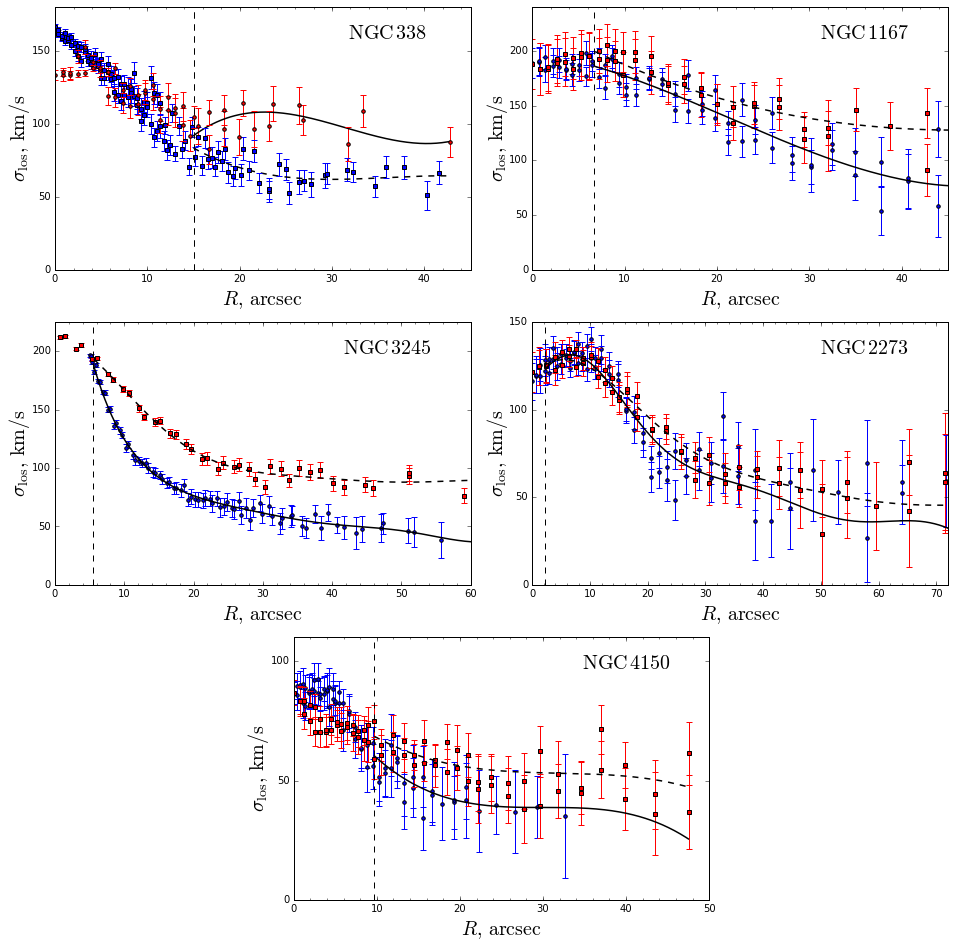

In [78]:
os.chdir(tex_imgs_dir)
# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12,8])

ind = 0
# Для 4150 - http://adsabs.harvard.edu/cgi-bin/bib_query?2010ApJ...716..942F, 
# для 3245 - http://adsabs.harvard.edu/cgi-bin/bib_query?2012ApJ...754...67F
rebs = [r_eb, 6.7, 5.5, 2.2, np.power(10, 2.81)/(13.74*10**6)*180*60*60/np.pi]
names  = [r'$\rm{NGC\, 338}$', r'$\rm{NGC\, 1167}$', r'$\rm{NGC\, 3245}$', r'$\rm{NGC\, 2273}$', r'$\rm{NGC\, 4150}$']

fig = plt.figure(figsize=[16,16])
ax1 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax5 = plt.subplot2grid((3,4), (2,1), colspan=2)
axes = [ax1, ax2, ax3, ax4, ax5]

plot_n338_svelos(ax1)

for name in ['n338', 'n1167', 'n3245', 'n2273', 'n4150']:
    ax = axes[ind]
    reb = rebs[ind]
    if name != 'n338':
        a,b,c = zip(*np.load(name + '_maj.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b,c = zip(*np.load(name + '_min.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='s', markersize=3.5, mew=1, color='red')
        a,b = zip(*np.load(name + '_maj_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ax.plot(a,b, '-', color='black', lw=1.5)
        a,b = zip(*np.load(name + '_min_poly.npy'))
        a_len = len(a)
        a = filter(lambda l: l > reb, a)
        b = b[(a_len-len(a)):]
        ax.plot(a,b, '--', color='black', lw=1.5)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
#     ax.plot([reb, reb],[0, (50 - 30*(ind/2))], color='black', lw=2)
    ax.axvline(x=reb, ls='--', color='black')
    ax.text(0.8, 0.9, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ax.yaxis.set_label_coords(-0.055, 0.5)
    ax.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=20)
    ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ind += 1

ax1.set_xlim(0, 45)
ax1.set_ylim(0)    

ax2.set_ylim(0, 240)
ax2.set_xlim(0, 45)
# ax2.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=15)

ax3.set_ylim(0, 225)
ax3.set_xlim(0, 60)
# ax3.axes.yaxis.set_ticklabels([])

ax4.set_ylim(0, 150)
ax4.set_xlim(0, 72)
# ax4.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=10)
# ax4.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=15)

ax5.set_ylim(0, 110)
# ax5.set_xlim(0, 50)
# ax5.axes.yaxis.set_ticklabels([])
# ax5.set_ylabel(r'$\sigma_{\rm{los}},\, \rm{km/s}$', fontsize=20)
# ax5.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)


fig.subplots_adjust(wspace=0.35, hspace=0.20)
# plt.savefig('all_sig_los.eps', format='eps')
# plt.savefig('all_sig_los.png', format='png')
# plt.savefig('all_sig_los.pdf', format='pdf', dpi=150)
plt.show()

chi_ma1	chi_ma2	chi_mi1	chi_mi2
7.520	1.344	13.476	5.066
ma: 4.432 +/- -3.088
mi: 9.271 +/- -4.205


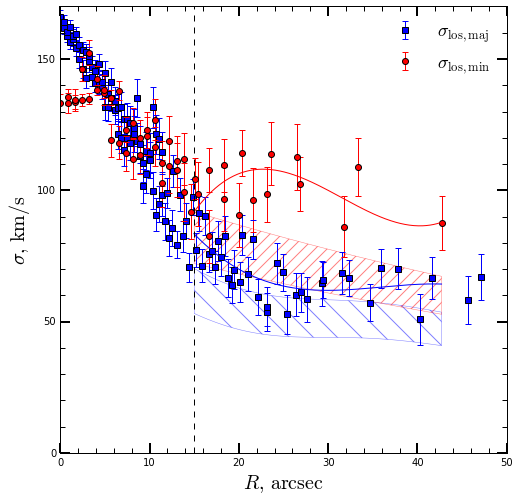

In [79]:
os.chdir(tex_imgs_dir)

points = np.arange(r_eb, max(radii_min), 0.1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
# ax.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p,  
#             label=r'$\sigma_{\rm{los}}^{\rm{maj}}$', fmt='.', marker='s', mew=1, color='blue',zorder=1)
# ax.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, 
#             label=r'$\sigma_{\rm{los}}^{\rm{min}}$', fmt='.', marker='o', mew=1, color='red',zorder=1)
ax.errorbar(radii_maj_t, sig_maj_p_t, yerr=e_sig_maj_p_t,  
             label=r'$\sigma_{\rm{los, maj}}$', fmt='.', marker='s', mew=1, color='blue')
ax.errorbar(radii_min_t, sig_min_p_t, yerr=e_sig_min_p_t, 
             label=r'$\sigma_{\rm{los, min}}$', fmt='.', marker='o', mew=1, color='red')
# ax.axvline(x=cutted, color='black', zorder=0)
lg = plt.legend(numpoints=1, fontsize=18)
lg.draw_frame(False)
ax.set_xlabel(r'$R,\,\rm{arcsec}$', fontsize=20)
ax.set_ylabel(r'$\sigma,\,\rm{km/s}$', fontsize=20)
# ax.set_xlim(r_eb)
ax.set_xlim(0)
ax.set_ylim(0, 170)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(10))
# ax.axes.yaxis.set_ticklabels([0, 50, 100, 150])
ax.tick_params('both', length=10, width=2, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
# ax.yaxis.tick_right()

alpha = 0.25
# sig_R_0 = 130.
sig_R_0 = 70.
ma1 = [sig_maj_exp(R) for R in points]
mi1 = [sig_min_exp(R) for R in points]
chi_ma1 = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
chi_mi1 = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
alpha = 0.7
# sig_R_0 = 150.
sig_R_0 = 85.
ma2 = [sig_maj_exp(R) for R in points]
mi2 = [sig_min_exp(R) for R in points]
chi_ma2 = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
chi_mi2 = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])

print '%s\t%s\t%s\t%s' % ('chi_ma1', 'chi_ma2', 'chi_mi1', 'chi_mi2')
print '%.3f\t%.3f\t%.3f\t%.3f' % (chi_ma1, chi_ma2, chi_mi1, chi_mi2)

print 'ma: %.3f +/- %.3f' % ( (chi_ma2 + chi_ma1)/2,  chi_ma2 - (chi_ma2 + chi_ma1)/2)
print 'mi: %.3f +/- %.3f' % ( (chi_mi2 + chi_mi1)/2,  chi_mi2 - (chi_mi2 + chi_mi1)/2)

ax.fill_between(points, mi1, mi2, color='none', alpha=0.5, zorder=1, hatch="//", edgecolor="r", lw=0.5)
ax.fill_between(points, ma1, ma2, color='none', alpha=0.5, zorder=0, hatch="\\", edgecolor="b", lw=0.5)

plt.plot(points, spl_maj(points), '-', color='blue')
plt.plot(points, spl_min(points), '-', color='red')

plt.axvline(x=r_eb, color='black', ls='--')
    
# plt.savefig('ngc338_svedata.ps', format='ps', rasterized=True, dpi=150)
# plt.savefig('ngc338_svedata.png', format='png', dpi=150)
# plt.savefig('ngc338_svedata.pdf', format='pdf', dpi=150)
plt.show()

Карта для $\chi^2$ <a id='map'></a>

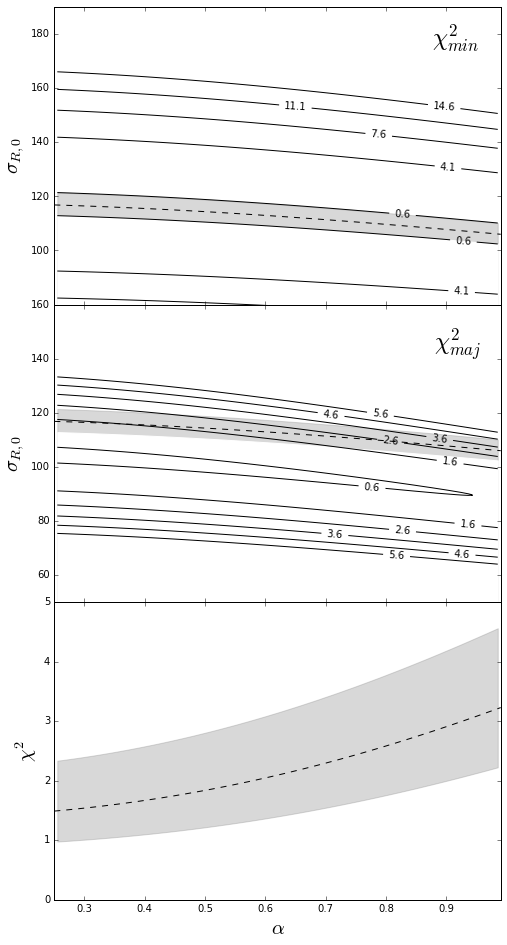

In [80]:
alphas = np.arange(0.25, 1., 0.01)
# sigmas = np.arange(100.0, 200, 0.25)
sigmas = np.arange(40.0, 200, 0.25)

import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
# levels = np.linspace(start=image_min.min()-2.7, 10., num=5)
# levels = [image_min.min()+0.02, image_min.min()+0.4, image_min.min()+1.1, image_min.min()+2.1, 
#           image_min.min()+3.1, image_min.min()+4.1]
# levels = np.linspace(start=image_min.min()+0.1, stop=image_min.min()+4.1, num=5)
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
levels = np.linspace(start=image_min.min()*1.2, stop=image_min.min()*1.1+14, num=5)

cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()

v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{min}$', size = 24.)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{min}$', size = 24.)
# ax.text(0.9, 180, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
# ax.set_ylim(100, 180)
ax.set_ylim(80, 190)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')

ax = axes[1]
ax.set_ylim(50, 160)
# levels = np.append(np.linspace(start=image_maj.min()+0.1, stop=image_maj.min()+4.1, num=6), np.array([image_maj.min()+0.25]))
levels = np.linspace(start=image_maj.min()*1.1, stop=image_maj.min()*1.1+5, num=6)
# levels = [image_maj.min()+0.1, image_maj.min()+0.25, image_maj.min()+1.1, image_maj.min()+2.1, image_maj.min()+3.1, 
#           image_maj.min()+4.1]
levels = sorted(levels)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{maj}$', size = 24.)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')

ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
# ax.set_ylim(120, 200)
# ax.set_ylim(50, 160)

ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)


import scipy.interpolate as sp
try:
    f1 = sp.interp1d(x2, err_maj1, kind='linear')
    ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
except Exception:
    f2 = sp.interp1d(x1, err_maj2, kind='linear')
    ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)

ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

ax.set_ylim(0.0, 5.0)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.25, 0.99)

plt.savefig('ngc338_maps.eps', format='eps')
plt.savefig('ngc338_maps.png', format='png')
plt.savefig('ngc338_maps.pdf', format='pdf', dpi=150)

plt.show()

In [81]:
# #новая карта для измененного способа подсчета

# alphas = np.arange(0.25, 1., 0.01)
# sigmas = np.arange(100.0, 200, 0.25)

# import matplotlib.mlab as mlab
# import matplotlib

# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
# ax = axes[0]
# # levels = np.linspace(start=image_min.min()-2.7, 10., num=5)
# # levels = [image_min.min()+0.02, image_min.min()+0.4, image_min.min()+1.1, image_min.min()+2.1, 
# #           image_min.min()+3.1, image_min.min()+4.1]
# # levels = np.linspace(start=image_min.min()+0.1, stop=image_min.min()+4.1, num=5)
# levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
# cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
# min_map_gutter = cset.collections[0].get_paths()

# v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
# x1,x2 = v1[:,0], v2[:,0]
# y1,y2 = v1[:,1], v2[:,1]
# plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{min}$', size = 24.)
# ax.set_ylabel('$\sigma_{R,0}$', size=20.)
# xx = np.arange(0.25, 1.0, 0.01)
# ax.plot(xx, map(main_slice, xx), '--', color='black')
# ax.set_ylim(100, 180)


# min_sigmas = np.where(image_min < image_min.min() + 0.03)
# slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
# slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
# slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# # ax.plot(slice_alph, slice_sig, '.', color='pink')
# poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# # ax.plot(xx, poly_slice(xx), '.-', color='black')
# ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
# ax.fill_between(x2, y2, 0, color='white')

# ax = axes[1]
# levels = np.append(np.linspace(start=image_maj.min()+0.1, stop=image_maj.min()+4.1, num=6), np.array([image_maj.min()+0.25]))
# # levels = np.linspace(start=image_maj.min()*1.1, stop=image_maj.min()*1.1+5, num=6)
# # levels = [image_maj.min()+0.1, image_maj.min()+0.25, image_maj.min()+1.1, image_maj.min()+2.1, image_maj.min()+3.1, 
# #           image_maj.min()+4.1]
# cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
# plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 172, '$\chi^2_{maj}$', size = 24.)
# ax.set_ylabel('$\sigma_{R,0}$', size=20.)
# xx = np.arange(0.25, 1.0, 0.01)
# ax.plot(xx, map(main_slice, xx), '--', color='black')

# ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
# ax.fill_between(x2, y2, 0, color='white')
# ax.set_ylim(120, 190)

# ax = axes[2]
# err_maj = []
# for al in alphas:
#     global alpha, sig_R_0
#     alpha = al
#     sig_R_0 = main_slice(al)
#     sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
#     err_maj.append(sqerr_maj)
# ax.plot(alphas, err_maj, '--', color='black')
# err_maj1 = []
# for pa in zip(x2,y2):
#     global alpha, sig_R_0
#     alpha = pa[0]
#     sig_R_0 = pa[1]
#     sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
#     err_maj1.append(sqerr_maj)
# # ax.plot(x2, err_maj1, '-', color='black')
# err_maj2 = []
# for pa in zip(x1,y1):
#     global alpha, sig_R_0
#     alpha = pa[0]
#     sig_R_0 = pa[1]
#     sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
#     err_maj2.append(sqerr_maj)
# # ax.plot(x1, err_maj2, '-', color='black')
# ax.set_ylabel(r'$\chi^2$', size=20.)
# ax.set_xlabel(r'$\alpha$', size=20.)


# import scipy.interpolate as sp
# f1 = sp.interp1d(x2, err_maj1, kind='linear')
# ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
# f2 = sp.interp1d(x1, err_maj2, kind='linear')
# ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)

# ax.set_ylabel(r'$\chi^2$', size=20.)
# ax.set_xlabel(r'$\alpha$', size=20.)

# # ax.set_ylim(3., 3.8)


# fig.subplots_adjust(hspace=0.)
# axes[0].yaxis.get_major_ticks()[0].set_visible(False)
# axes[1].yaxis.get_major_ticks()[0].set_visible(False)
# ax.set_xlim(0.25, 0.99)

# plt.savefig('ngc338_maps.eps', format='eps')
# plt.savefig('ngc338_maps.png', format='png')
# plt.savefig('ngc338_maps.pdf', format='pdf', dpi=150)

# plt.show()

# Какая-то проблема здесь - где-то потеряны нормировки, строит график  [выше](#ad)

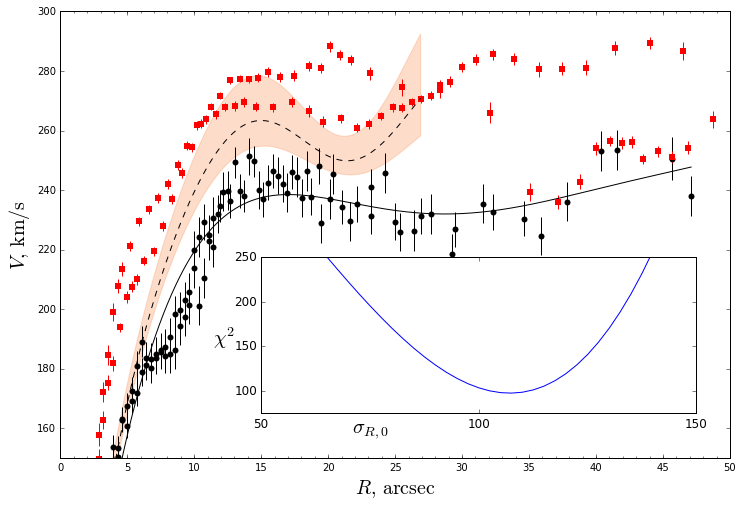

In [82]:
majorLocator   = MultipleLocator(5)
majorFormatter = FormatStrFormatter('%d')
minorLocator   = MultipleLocator(1)

os.chdir(tex_imgs_dir)

spl_min = spl_min1

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# sigmas = [112., 185.]
sigmas = [87., 137.]
test_points = np.arange(0.0, max(r_ma_b), 0.1)

ax.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='o', mew=0, color='black')
ax.plot(test_points, poly_star(test_points), '-', color='black', label=r'$V_{\varphi}$')

sig_R_0 = sigmas[0]
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
pg1 = [predict_gas(R) for R in test_points_z]
sig_R_0 = sigmas[1]
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
pg2 = [predict_gas(R) for R in test_points_z]

ax.fill_between(test_points_z, pg1, pg2, color=plt.cm.RdYlBu(0.5/len(sigmas)), alpha=0.3)

ax.errorbar(r_g_b[:-1], vel_g_b[:-1], yerr=e_vel_g_b[:-1], fmt='.', marker='s', mew=0, color='red')
    
# sig_R_0 = 152.5
sig_R_0 = 107.5
poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
ax.plot(test_points_z, [predict_gas(R) for R in test_points_z], 
     '--', label='possible value', color='black', mfc='none', markersize=1)


rect = [0.3, 0.1, 0.65, 0.35]
ax1 = add_subplot_axes(ax,rect)

sigmas = np.arange(60.0, 250, 2.5)
ax1.plot(sigmas, drift_err, '-')
# ax1.set_ylim(0, 200)
ax1.set_ylim(75, 250)
# ax1.set_xlim(100, 200)
ax1.set_xlim(50, 150)
ax1.set_ylabel(r'$\chi^2$', rotation=0, fontsize=20)
ax1.yaxis.set_label_coords(-0.085, 0.4)
# ax1.set_xticks([100, 150, 200])
ax1.set_xticks([50, 100, 150])
ax1.set_xlabel(r'$\sigma_{R,0}$', fontsize=20)
ax1.xaxis.set_label_coords(0.25, -0.05)


# ax1.set_xlim(0, 27.)
# ad = [sqrt(abs(asym_drift_value(R) + poly_star(R)**2)) for R in test_points_z]
# dif = [abs(ad[i] - poly_star(test_points[i])) for i in range(test_points_z.__len__())]
# ax1.plot(test_points_z, dif, '-.', lw=1, color = 'black', label = 'gas diff')
# # ax1.fill_between(test_points_z, 0, dif, color = 'pink')
# dif2 = [abs(predict_gas(R) - vel_g_b[np.where(r_g_b==R)[0][0]]) for R in filter(cut, r_g_b)]
# ax1.plot(filter(cut, r_g_b), dif2, '+', color = 'black', label = 'gas diff')
# # ax1.fill_between(filter(cut, r_g_b), 0, dif2, color = 'yellow')
# ax1.set_yticks([25, 50])
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.xaxis.set_minor_locator(minorLocator)
ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
ax.set_ylabel(r'$V,\, \rm{km/s}$', fontsize=20)
ax.set_ylim(150, 300)
ax.set_xlim(0, 50)

# plt.savefig('ngc338_ad.ps', format='ps', orientation='landscape')
# plt.savefig('ngc338_ad.png', format='png')
# plt.savefig('ngc338_ad.pdf', format='pdf', dpi=150)
plt.show()

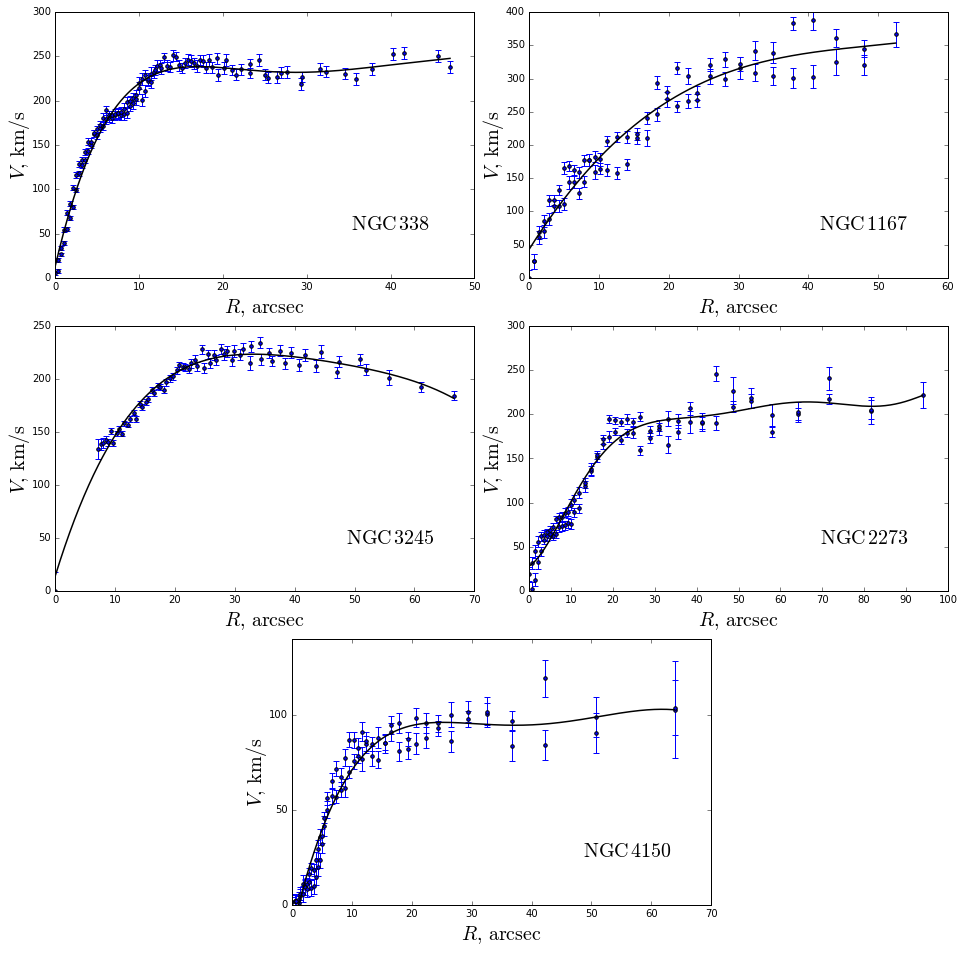

In [83]:
os.chdir(tex_imgs_dir)

ind = 0
names  = [r'$\rm{NGC\, 338}$', r'$\rm{NGC\, 1167}$', r'$\rm{NGC\, 3245}$', r'$\rm{NGC\, 2273}$', r'$\rm{NGC\, 4150}$']

fig = plt.figure(figsize=[16,16])
ax1 = plt.subplot2grid(shape=(3,4), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((3,4), (0,2), colspan=2)
ax3 = plt.subplot2grid((3,4), (1,0), colspan=2)
ax4 = plt.subplot2grid((3,4), (1,2), colspan=2)
ax5 = plt.subplot2grid((3,4), (2,1), colspan=2)
axes = [ax1, ax2, ax3, ax4, ax5]


for name in ['n338', 'n1167', 'n3245', 'n2273', 'n4150']:
    ax = axes[ind]
    if name == 'n338':
        ax.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        tps = np.arange(0.0, max(r_ma_b), 0.1)
        ax.plot(tps, poly_star(tps), '-', color='black', lw=1.5)  
    else:
        a,b,c = zip(*np.load(name + '_maj_rot.npy'))
        ax.errorbar(a, b, yerr=c, fmt='.', marker='o', markersize=3.5, mew=1, color='blue')
        a,b = zip(*np.load(name + '_rot_poly.npy'))
        ax.plot(a,b, '-', color='black', lw=1.5) 
    ax.text(0.8, 0.2, names[ind], fontsize=20, ha='center', va='center', transform=ax.transAxes)
    ax.yaxis.set_label_coords(-0.055, 0.5)
    ax.set_ylabel(r'$V,\, \rm{km/s}$', fontsize=20)
    ax.set_xlabel(r'$R,\, \rm{arcsec}$', fontsize=20)
    ax.set_ylim(0)
    ax.xaxis.set_major_locator(MultipleLocator(10))
#     ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ind += 1
    
ax2.set_ylim(0, 400)

fig.subplots_adjust(wspace=0.3, hspace=0.18)
# plt.savefig('all_rot_curv.eps', format='eps')
# plt.savefig('all_rot_curv.png', format='png')
# plt.savefig('all_rot_curv.pdf', format='pdf', dpi=150)
plt.show()

# Дальше не пересчитывали.  ==========================================

## 3. Отношение вертикальной дисперсии к радиальной 

Если мы с высокой достоверностью определили $\sigma_R$, то какое значение $\alpha$ ему соответствует? Посчитать нужный профиль мы можем простым вычитанием: $$\sigma_Z = \frac{1}{\cos i}\sqrt{\sigma_{los,min}^2 - \sigma_R^2\sin^2i}$$ После вычитания мы сможем проверить, какое получается отношение $\alpha$ вдоль профиля (оно в силу формул будет константой, но какой?).

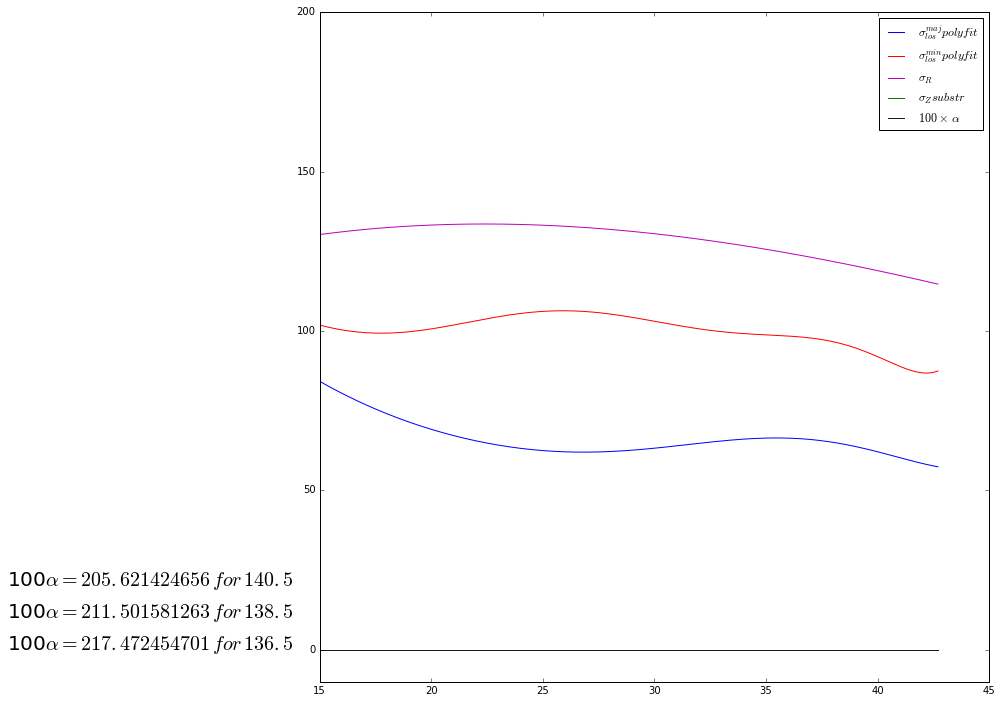

In [84]:
#Пусть это наиболее вероятное значение sigR_0
sig_R_0 = 138.5
#Его вероятная ошибка
dsig_R0 = 2.

def sigZ_from_substr(R):
    '''Вычисление sigZ вичитанием готового профиля sigR'''
    sq2 = poly_sig_min(R)**2 - sigR_exp(R)**2 * sin_i**2
    if sq2 > 0:
        return sqrt(sq2)/cos_i
    else:
        return 0.0


plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(points, [sigR_exp(R) for R in points], label = '$\sigma_R$', color='m')
plt.plot(points, [sigZ_from_substr(R) for R in points], label = '$\sigma_Z substr$', color='g')
plt.plot(points, [100*sigZ_from_substr(R)/sigR_exp(R) for R in points], 
         '-', label = r'$100\times\,\alpha$', color=(0.1,0.1,0.1))
plt.text(1, 10, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

#Верхняя граница
sig_R_0 = sig_R_0 - dsig_R0
plt.text(1, 0, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

#Нижняя граница
sig_R_0 = sig_R_0 + 2*dsig_R0
plt.text(1, 20, r"100$\alpha=%s\, for\, %s$" % 
         (100*sigZ_from_substr(0.)/sigR_exp(0.), sig_R_0), fontsize=20, color='black')

plt.legend()
plt.ylim(-10, 200)
plt.show()

## 4. Приложения

### 4.1 Хаббловские типы

Shapiro и Gerssen в статье 2003 года (http://arxiv.org/abs/astro-ph/0308489) "Observational Constraints on Disk Heating as a Function of Hubble Type" пытались проследить зависимость отношения $\sigma_Z/\sigma_R$ для галактик разных хаббловских типов. Неплохо было бы ради интереса на их график добавить и нашу полученную точку. У 338 тип Sab, т.е. располагается она чуть правее крайней левой отметки.

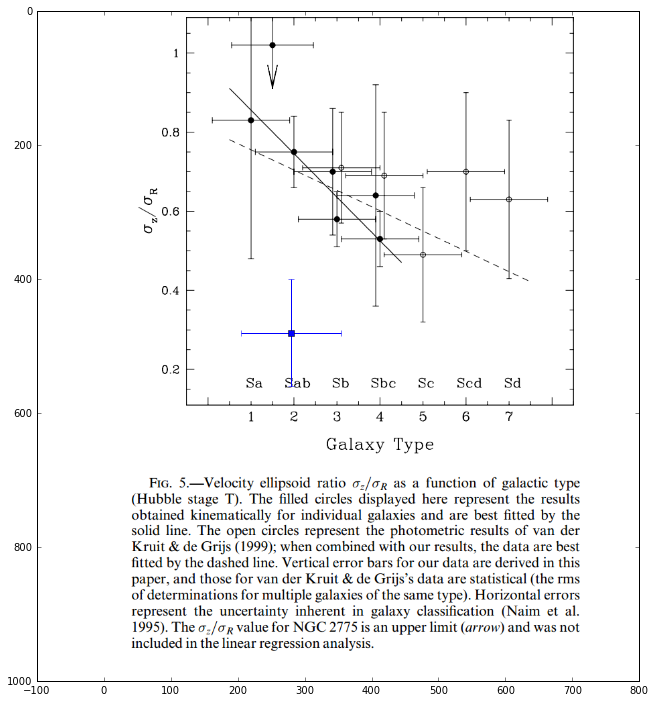

In [85]:
os.chdir("C:\\science\\2FInstability\\notebooks")

plt.imshow(np.asarray(pil.Image.open("shapiro_2003_hubble_type.png")))
# Значение, которое мы получили только что
plt.plot(280, 480, 's', color='blue')
plt.errorbar(280, 480, yerr=80, xerr=75, color='blue')
# plt.text(260, 540, "$Sab$", fontsize=20, color='red')
plt.ylim(1000, 0)
plt.show()

### 4.2 Кинетический масштаб

Еще одна важная идея, на которую тоже интересно посмотреть - кинематический масштаб. Gerssen и Shapiro в своих работах восстанавливают профиль дисперсий скоростей исходя из предположения об его экспоненциальной форме: $$\sigma_R = \sigma_{R,0}\exp(-R/h_{kin}),$$ $$\sigma_Z = \sigma_{Z,0}\exp(-R/h_{kin}),$$ где характерный экспоненциальный масштаб предполагается равным для обоих профилей (и это и есть кинематический масштаб). Из неких предположений следует, что этот масштаб равен удвоенному масштабу диска: $h_{kin}=2h_d$, но это проверять на будущее - когда будет известна фотометрия.  

Найдем кинетический масштаб и профили, которые получились бы у них для NGC 338. Сделать это довольно легко: $$\sigma_{los,min}^2 = \sigma_R^2\sin^2i + \sigma_Z^2\cos^2i,$$ а значит из предположения выше $$\sigma_{los,min}^2 = \exp(-2R/h_{kin})\times(\sigma_{R,0}^2\sin^2i + \sigma_{Z,0}^2\cos^2i),$$ а если взять логарифм: $$2\ln\sigma_{los,min} = -2R/h_{kin} + \ln(\rm{const}).$$ Приблизим точки прямой и константа при y будет равно обратному кинематическому масштабу. 

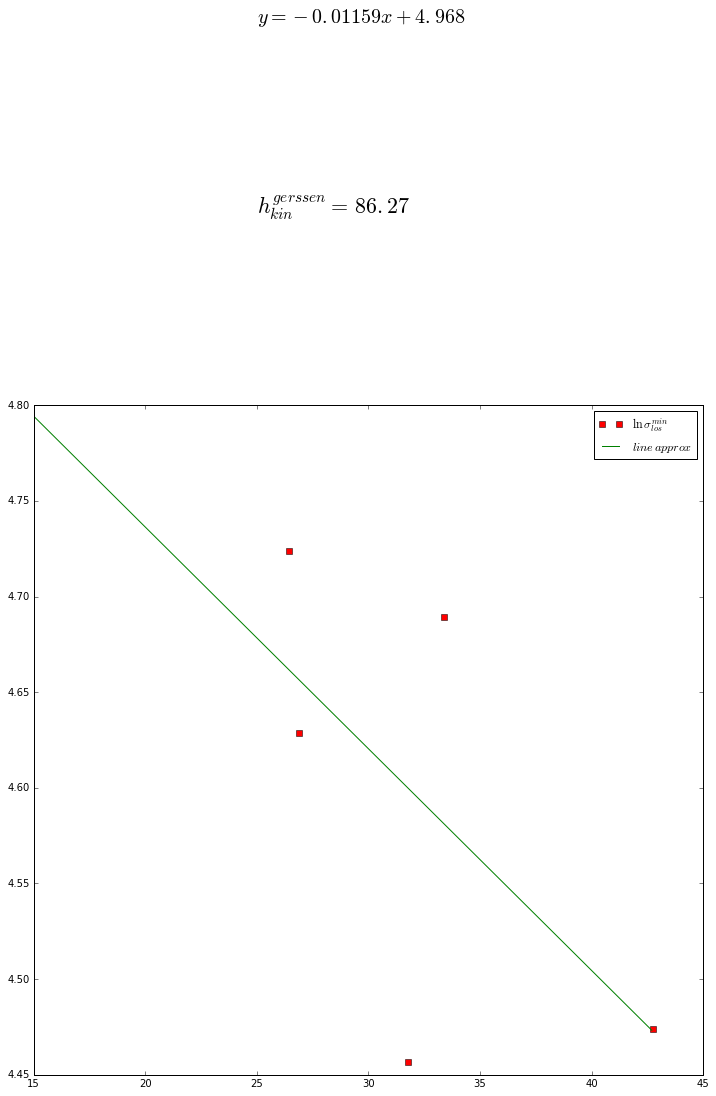

In [86]:
import math

sig_min_p_ln = [math.log(p) for p in sig_min_p]

poly_ln = poly1d(polyfit(radii_min, sig_min_p_ln, deg=1))
h_kin_gerssen = float("{0:.2f}".format(-1./poly_ln[1]))

plt.plot(radii_min, sig_min_p_ln, 's', label='$\ln\,{\sigma_{los}^{min}}$', color='red')
plt.plot(points, [poly_ln(R) for R in points], label = '$line\, approx$', color='g')
plt.text(25, 5.0, r"$y=%s$" % poly_ln.__str__()[2:], fontsize=20, color='black')
plt.text(25, 4.9, r"$h_{kin}^{gerssen}=\,%s$" % h_kin_gerssen, fontsize=22, color='black')

plt.legend()
plt.show()

Запишем МНК, решив которую мы сможем также найти $\alpha$ при данном $h_{kin}$ (идея как и раньше, раз мы взяли герсеновскую параметризацию профилей). В дипломе такое не было сделано - просто брали $\alpha=0.5$.
Неизвестные: $\sigma_{R,0}^2\sin^2 i \equiv A,\ \sigma_{R,0}^2\cos^2 i\times \alpha^2 \equiv B$.
$$\left\{
  \begin{array}{lr}
    \sigma_{los,maj}^2(R_j)=\exp(-2R_j/h_{kin})\times[Af(R_j)+B]\\
    \sigma_{los, min}^2(R_j)=\exp(-2R_j/h_{kin})\times[A+B]
  \end{array}
\right.
$$

In [87]:
#Как вычислять ошибку 
def residuals(params, xdata, ydata):
            return (ydata - np.dot(xdata, params))

def lsq_alpha_gerssen(h_kin):
    '''
    МНК для нахождения alpha методом примерно как у Gerssen - экспоненциальные профили. 
    Считаем честно для наблюдательных точек.
    '''
    #Начальное приближение (А,В)
    x0 = [1000, 1000]
    
    #Уравнения:
    #Левая часть:
    eq_left = np.concatenate( ([p[1]**2/exp(-2*p[0]/h_kin) for p in zip(radii_maj, sig_maj_p)], 
                               [p[1]**2/exp(-2*p[0]/h_kin) for p in zip(radii_min, sig_min_p)]) )
    #Правая часть:
    eq_right = np.transpose(
                np.array([
                    np.concatenate(([sigPhi_to_sigR(R)**2 for R in radii_maj], 
                                    [1.]*radii_min.__len__())),
                    np.concatenate(([1.]*radii_maj.__len__(), 
                                    [1.]*radii_min.__len__()))]))
    
    # МНК для получившихся уравнений:
    solution = scipy.optimize.leastsq(residuals, x0, args=(eq_right, eq_left))[0]
    A, B = solution[0], solution[1]
    
    chi2 = sum(power(residuals(solution, eq_right, eq_left), 2))
            
    print 'Solution: A = %s, B = %s' % (A, B)
    print 'Chi^2:', chi2
    
    sig_R_0 = round( sqrt(A) / sin(incl*pi/180), 3)
    alpha = round( sqrt(B)/ (cos(incl*pi/180) * sig_R_0), 3)
    
    print "sig_R_0 = %s, alpha = %s" % (sig_R_0, alpha)
    return sig_R_0, alpha
    
lsq_alpha_gerssen(h_kin_gerssen)

Solution: A = 23461.9956494, B = -2524.90379511
Chi^2: 122719931.234


ValueError: math domain error

Да, такой результат действительно лучше вписывается в тренд для хаббловских типов. Попробуем еще то же, но с $h_{kin}=2h_d$:


In [ ]:
lsq_alpha_gerssen(2 * h_d)

Не похоже на правду. Возьмем в последний раз $h_{kin}\, примерно\, 50$:

In [ ]:
lsq_alpha_gerssen(50.)

Заведем функции для восстановления профиля при герсеновских экспоненциальных предположениях. 

In [ ]:
def sigR_ger_exp(R):
    return sig_R_0*exp(-R/h_kin_gerssen)

def sigZ_ger_exp(R):
    return sigR_ger_exp(R)*alpha

def sigPhi_ger_exp(R):
    return sigPhi_to_sigR(R) * sigR_ger_exp(R)

def sig_maj_ger_exp(R):
    return sqrt(sigPhi_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

def sig_min_ger_exp(R):
    return sqrt(sigR_ger_exp(R)**2 * sin_i**2 + sigZ_ger_exp(R)**2 * cos_i**2)

In [ ]:
sig_R_0, alpha = lsq_alpha_gerssen(h_kin_gerssen)

plt.plot(points, [sigR_ger_exp(R) for R in points], '-', color='red', label='$\sigma_{R, exp}^{gers}$')
plt.plot(points, [sigPhi_ger_exp(R) for R in points], '-', color='blue', label=r'$\sigma_{\varphi, exp}^{gers}$')
plt.plot(points, [sigZ_ger_exp(R) for R in points], '-', color='black', label='$\sigma_{Z, exp}^{gers}$')
plt.plot(points, poly_sig_maj(points), '-', label = '$\sigma_{los}^{maj} polyfit$', color='m')
plt.plot(points, [sig_maj_ger_exp(R) for R in points], '--', color='m', label='$\sigma_{maj, exp}^{gers}$')
plt.plot(points, poly_sig_min(points), '-', label = '$\sigma_{los}^{min} polyfit$', color='y')
plt.plot(points, [sig_min_ger_exp(R) for R in points], '--', color='y', label='$\sigma_{min, exp}^{gers}$')

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='m')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='m')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='y')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='y')

plt.legend()
plt.show()

Определим теперь, какой кинетический масштаб получается в нашем способе, непосредственно приблизив профили $\ln \sigma_R(R)$ и $\ln \sigma_Z(R)$ прямыми как и раньше:

In [ ]:
sig_R_0 = 141.
alpha = 0.3

sig_R_p_ln = [math.log(p) for p in [sigR_exp(R) for R in points]]
sig_Z_p_ln = [math.log(p) for p in [sigZ_exp(R) for R in points]]

poly_ln_R = poly1d(polyfit(points, sig_R_p_ln, deg=1))
h_kin_R = float("{0:.2f}".format(-1./poly_ln_R[1]))

poly_ln_Z = poly1d(polyfit(points, sig_Z_p_ln, deg=1))
h_kin_Z = float("{0:.2f}".format(-1./poly_ln_Z[1]))

plt.plot(points, sig_R_p_ln, 'o', label='$\ln\,{\sigma_R}$', color='red')
plt.plot(points, [poly_ln_R(R) for R in points], label = '$line\, approx$', color='r')
plt.text(25, 4.9, r"$y_R=%s$" % poly_ln_R.__str__()[2:], fontsize=20, color='black')
plt.text(25, 5.0, r"$h_{kin}^{R}=\,%s$" % h_kin_R, fontsize=22, color='black')

plt.plot(points, sig_Z_p_ln, 's', label='$\ln\,{\sigma_Z}$', color='b')
plt.plot(points, [poly_ln_Z(R) for R in points], label = '$line\, approx$', color='b')
plt.text(5., 4., r"$y_Z=%s$" % poly_ln_Z.__str__()[2:], fontsize=20, color='black')
plt.text(5., 4.1, r"$h_{kin}^{Z}=\,%s$" % h_kin_Z, fontsize=22, color='black')

plt.legend()
plt.show()

### 4.3 Уточнение линейной теории

Если мы достаточно точно оценим сверху $\sigma_{R}$: $\sigma_{R}^{up} \gtrsim \sigma_{R}$, то мы сможем написать нижнюю оценку на $\frac{\sigma_Z}{\sigma_R}$ и сравнить ее с 0.3. После несложных подсчетов получается следующая оценка:
$$\sqrt{(\sigma_{los,min}^2-\sigma_{R}^{2,up}\sin^2i)/(\sigma_{R}^{2,up}\cos^2i)} < \alpha$$

### Виджеты

Научимся добавлять виджеты - очень удобно, чтобы анализировать данные вручную

In [ ]:
from IPython.html.widgets import *


def widget_plot_profiles(sigma_R_0, alpha_val):
    global alpha, sig_R_0
    alpha = alpha_val
    sig_R_0 = sigma_R_0
    fig = plt.figure(figsize=(7,7))
    plt.title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (alpha,sig_R_0))
    plt.plot(points, spl_maj(points), '-', color='blue', label='maj spline')
    plt.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue', label = 'maj exp')
    plt.plot(points, spl_min(points), '-', color='red', label='min spline')
    plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red', label = 'min exp')
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
#     sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
#     sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
    plt.text(10, 5, "$\chi^2_{maj}=%5.0f\, \chi^2_{min}=%5.0f$" % (sqerr_maj, sqerr_min), fontsize=12)
    plt.ylim(0, 170)
    plt.xlim(cutted, 45)
    plt.legend()

interact(widget_plot_profiles, sigma_R_0=(100, 200, 0.5), alpha_val=(0.25, 1.0, 0.01));

In [ ]:
def widget_plot_shift(sigma_R_0):
    global sig_R_0, poly_marj_R
    fig = plt.figure(figsize=(10, 10))
    plt.plot(r_g_b, vel_g_b, 's', label = 'Zasov gas', color='red')
    plt.errorbar(r_g_b, vel_g_b, yerr=e_vel_g_b, fmt='.', marker='.', mew=0, color='red')
    plt.ylim(0, 350)
    plt.xlim(0, 65)
    sig_R_0 = sigma_R_0
    poly_marj_R = poly1d(polyfit(points, [sigR_exp(R) for R in points], deg=7))
    plt.plot(test_points, [predict_gas(R) for R in test_points], '--', color='black', label=('%s' % sig_R_0), lw=0.5, ms=0.5)
    plt.legend(loc='lower right')

interact(widget_plot_shift, sigma_R_0=(100, 200, 1.));